In [49]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from random import randint, seed

import tensorflow as tf
import keras.backend as K
from tensorflow.keras import models, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Flatten, TimeDistributed, RepeatVector, Lambda

from scipy.ndimage.interpolation import shift


Here we will generate X and y parallel datasets such that y sequence will be the reverse of the given X sequence.

* Given sequence X[i] length of 4: X[i]=[3, 2, 9, 1]
* Output sequence (y[i]) is the reversed input sequence (X[i]): y[i]=[1, 9, 2, 3]

    In real life (like Machine Language Translation, Image Captioning, etc.), we are given (or build) a parallel dataset: X sequences and corresponding y sequences
    
Our aim is to code an Encoder-Decoder with Attention. However, I would like to develop the solution by showing the shortcomings of other possible approaches. Therefore, in the first 2 parts, we will observe that initial models have their own weaknesses. We also understand why Encoder-Decoder paradigm is so successful.

In [7]:
## Functions to generate a dummy Seq2Seq Dataset, 

# generate a sequence of random integers
def generate_sequence(length, n_unique):
    return [randint(0, n_unique-1) for _ in range(length)]


# one hot encode a sequence
def one_hot_encode(sequence, n_unique):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)


# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]


# prepare data for the LSTM. Input is a sequence of numbers, output is reverse of that sequence.
def get_reversed_pairs(time_steps, vocabulary_size, verbose=False):
    # generate random sequence
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]
    
    # one hot encode
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)
    
    # reshape as 3D
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))

    if(verbose):
        print('\nSample X and y')
        print('\nIn raw format:')
        print('X[0] = %s, \ny[0] = %s' % (one_hot_decode(X[0]), one_hot_decode(y[0])))
        print('\nIn one_hot_encoded format:')
        print('X[0] = %s' % (X[0]))
        print('\ny[0] = %s' % (y[0]))
    return X,y


def create_dataset(train_size, test_size, time_steps, vocabulary_size, verbose=False):
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs = np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs = np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]	

    if(verbose):
        print('\nGenerated sequence datasets as follows')
        print('X_train.shape: ', X_train.shape, 'y_train.shape: ', y_train.shape)
        print('X_test.shape: ', X_test.shape, 'y_test.shape: ', y_test.shape)

    return X_train, y_train, X_test, y_test

In [8]:
## Function to train & test a given model (Early Stopping monitor 'val_loss')

def train_test(model, X_train, y_train , X_test, y_test, epochs=500, verbose=0):
    
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    
    # train the model
    print('training for ',epochs,' epochs begins with EarlyStopping while monitoring val_loss...')
    history = model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, verbose=verbose, callbacks=[es])
    print(epochs,' epoch training finished...')

    
    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))

    
    # plotting the training history
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model.name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model.name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # spot check some examples
    print('Example predictions...')
    for _ in range(10):
        X, y = get_reversed_pairs(n_timesteps, n_features)
        yhat = model.predict(X, verbose=0)
        print('Input: ', one_hot_decode(X[0]),
              'Expected:', one_hot_decode(y[0]), 
              'Predicted', one_hot_decode(yhat[0]),
              '', np.array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])) )


In [9]:
# Configure parameters of the model and dataset

# each input sample will have 4 values
n_timesteps = 4

# each value is one_hot_encoded with 10 features (i.e. 0/1)
n_features = 10   

# generate random sequence
X,y = get_reversed_pairs(n_timesteps,  n_features, verbose=True)

# generate datasets
train_size= 20000 
test_size = 200 

X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, 
                                                  n_timesteps, n_features, verbose=True)


Sample X and y

In raw format:
X[0] = [0, 2, 9, 6], 
y[0] = [6, 9, 2, 0]

In one_hot_encoded format:
X[0] = [[1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0]]

y[0] = [[0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]

Generated sequence datasets as follows
X_train.shape:  (20000, 4, 10) y_train.shape:  (20000, 4, 10)
X_test.shape:  (200, 4, 10) y_test.shape:  (200, 4, 10)


### Multi-Layer Perceptron network

We will train a simple Multilayer Perceptron Network on the generated dataset to see how the model performs on it.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4, 10)]           0         
_________________________________________________________________
dense_5 (Dense)              (None, 4, 256)            2816      
_________________________________________________________________
dense_6 (Dense)              (None, 4, 128)            32896     
_________________________________________________________________
dense_7 (Dense)              (None, 4, 64)             8256      
_________________________________________________________________
dense_8 (Dense)              (None, 4, 10)             650       
Total params: 44,618
Trainable params: 44,618
Non-trainable params: 0
_________________________________________________________________


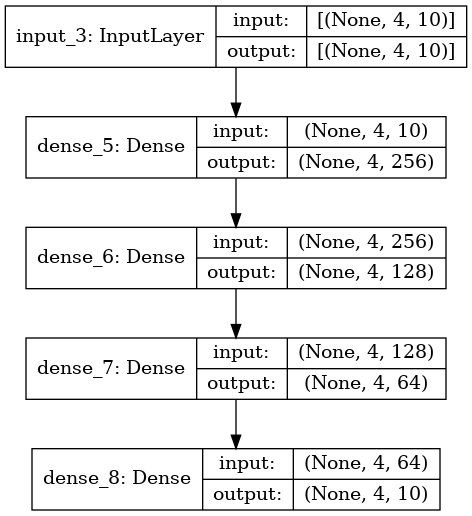

In [8]:
n_perceptrons = 64

model_input = Input(shape=(n_timesteps, n_features))
x = Dense(4*n_perceptrons)(model_input)
x = Dense(2*n_perceptrons)(x)
x = Dense(n_perceptrons)(x)
model_output = Dense(n_features, activation='softmax')(x)

mlp_model = Model(inputs=model_input, outputs=model_output)
mlp_model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
mlp_model.summary()

plot_model(mlp_model, show_shapes=True)

training for  500  epochs begins with validation_split = 0.1 & EarlyStopping(monitor= val_loss, patience=20)....


2021-10-14 17:05:49.678593: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-14 17:05:49.928236: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1999965000 Hz


Epoch 1/500
563/563 - 2s - loss: 2.3084 - accuracy: 0.1010 - val_loss: 2.3057 - val_accuracy: 0.0959
Epoch 2/500
563/563 - 1s - loss: 2.3036 - accuracy: 0.1000 - val_loss: 2.3057 - val_accuracy: 0.0889
Epoch 3/500
563/563 - 1s - loss: 2.3034 - accuracy: 0.0999 - val_loss: 2.3047 - val_accuracy: 0.0927
Epoch 4/500
563/563 - 1s - loss: 2.3034 - accuracy: 0.1004 - val_loss: 2.3045 - val_accuracy: 0.0944
Epoch 5/500
563/563 - 1s - loss: 2.3034 - accuracy: 0.1001 - val_loss: 2.3040 - val_accuracy: 0.0964
Epoch 6/500
563/563 - 1s - loss: 2.3033 - accuracy: 0.0990 - val_loss: 2.3041 - val_accuracy: 0.0945
Epoch 7/500
563/563 - 1s - loss: 2.3032 - accuracy: 0.1021 - val_loss: 2.3037 - val_accuracy: 0.0932
Epoch 8/500
563/563 - 1s - loss: 2.3031 - accuracy: 0.1024 - val_loss: 2.3042 - val_accuracy: 0.0955
Epoch 9/500
563/563 - 1s - loss: 2.3031 - accuracy: 0.1004 - val_loss: 2.3039 - val_accuracy: 0.1007
Epoch 10/500
563/563 - 1s - loss: 2.3029 - accuracy: 0.1021 - val_loss: 2.3035 - val_accura

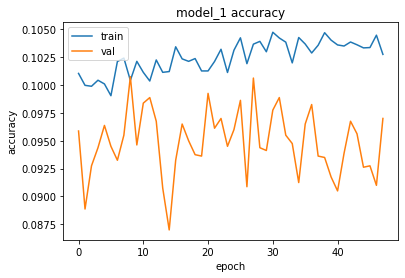

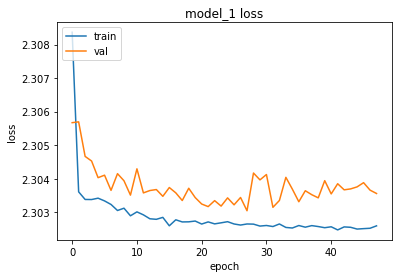

Example predictions...
Input:  [5, 6, 6, 5] Expected: [5, 6, 6, 5] Predicted [5, 5, 5, 5]  False
Input:  [5, 8, 9, 2] Expected: [2, 9, 8, 5] Predicted [5, 1, 0, 0]  False
Input:  [9, 6, 4, 5] Expected: [5, 4, 6, 9] Predicted [0, 5, 5, 5]  False
Input:  [0, 7, 6, 0] Expected: [0, 6, 7, 0] Predicted [3, 8, 5, 3]  False
Input:  [8, 0, 5, 5] Expected: [5, 5, 0, 8] Predicted [1, 3, 5, 5]  False
Input:  [7, 4, 8, 7] Expected: [7, 8, 4, 7] Predicted [8, 5, 1, 8]  False
Input:  [7, 1, 8, 8] Expected: [8, 8, 1, 7] Predicted [8, 1, 1, 1]  False
Input:  [7, 0, 5, 0] Expected: [0, 5, 0, 7] Predicted [8, 3, 5, 3]  False
Input:  [8, 1, 7, 8] Expected: [8, 7, 1, 8] Predicted [1, 1, 8, 1]  False
Input:  [4, 4, 0, 6] Expected: [6, 0, 4, 4] Predicted [5, 5, 3, 5]  False


In [9]:
train_test(mlp_model, X_train, y_train , X_test, y_test, verbose=2)

* We coded a simple Multi-Layer Perceptron (MLP) model by Keras Functional API
* We observed that MLP did not perfom well (about 10% accuracy)
* Using RNN could be a better idea to solve such problems

MLP is not able to learn Seq2Seq Learning. The main reason is that MLP pays attention to all its inputs equally and is not aware of the time dimensionality of the input-output relation. Thus, MLP can not relate input with output understanding the sequence order (time dimension)

### LSTM layer in a Recurrent Neural Network

LSTM has 3 important parameters:

* **units:** Positive integer, the dimensionality of the output space

* **return_sequences:** Boolean, whether to return the last output. In the output sequence, or the full sequence. Default: False.

* **return_state:** Boolean, whether to return the last state in addition to the output. Default: False.

The first parameter (units) indicates the dimension of the output vector/matrix.

The last 2 parameters (return_sequences and return_state) determines what the LSTM layer outputs. LSTM can return 4 different sets of results/states according to the given parameters:

* Default: Last Hidden State (Hidden State of the last time step)
![title](assets/default.png)
* return_sequences=True : All Hidden States (Hidden State of ALL the time steps)
![title](assets/return_sequence.png)
* return_state=True : Last Hidden State+ Last Hidden State (again!) + Last Cell State (Cell State of the last time step)
![title](assets/return_state.png)
* return_sequences=True + return_state=True: All Hidden States (Hidden State of ALL the time steps) + Last Hidden State (again!) + Last Cell State (Cell State of the last time step)
![title](assets/return_sequence+state.png)

Using these 4 different results/states we can stack LSTM layers in various ways

#### 1. LSTM with default output:

In [18]:
n_units = 16

model_input = Input(shape=(n_timesteps, n_features))
x = LSTM(16)(model_input)  # Single LSTM Layer with default output
x = RepeatVector(n_timesteps)(x)  # Repeat the output of LSTM n_timesteps (4 in our example)
model_output = Dense(n_features, activation='softmax')(x)

lstm_model = Model(model_input, model_output)
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', 
                   metrics=['accuracy'])
lstm_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4, 10)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                1728      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 16)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 4, 10)             170       
Total params: 1,898
Trainable params: 1,898
Non-trainable params: 0
_________________________________________________________________


training for  500  epochs begins with validation_split = 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/500
563/563 - 3s - loss: 1.8322 - accuracy: 0.3346 - val_loss: 1.4949 - val_accuracy: 0.3832
Epoch 2/500
563/563 - 1s - loss: 1.4239 - accuracy: 0.3852 - val_loss: 1.3762 - val_accuracy: 0.3834
Epoch 3/500
563/563 - 1s - loss: 1.3342 - accuracy: 0.3853 - val_loss: 1.3082 - val_accuracy: 0.3834
Epoch 4/500
563/563 - 1s - loss: 1.2797 - accuracy: 0.3853 - val_loss: 1.2653 - val_accuracy: 0.3832
Epoch 5/500
563/563 - 1s - loss: 1.2458 - accuracy: 0.3852 - val_loss: 1.2387 - val_accuracy: 0.3832
Epoch 6/500
563/563 - 1s - loss: 1.2251 - accuracy: 0.3851 - val_loss: 1.2231 - val_accuracy: 0.3831
Epoch 7/500
563/563 - 1s - loss: 1.2128 - accuracy: 0.3852 - val_loss: 1.2134 - val_accuracy: 0.3832
Epoch 8/500
563/563 - 1s - loss: 1.2049 - accuracy: 0.3852 - val_loss: 1.2071 - val_accuracy: 0.3834
Epoch 9/500
563/563 - 1s - loss: 1.1996 - accuracy: 0.3852 - val_loss: 1.2027 -

Epoch 81/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1892 - val_accuracy: 0.3834
Epoch 82/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 83/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1892 - val_accuracy: 0.3834
Epoch 84/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 85/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 86/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 87/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 88/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 89/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 90/500
563/563 - 1s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - v

Epoch 161/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 162/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 163/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 164/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 165/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 166/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 167/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 168/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 169/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 170/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 

Epoch 241/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 242/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 243/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 244/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 245/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 246/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 247/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 248/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 249/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 250/500
563/563 - 1s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 

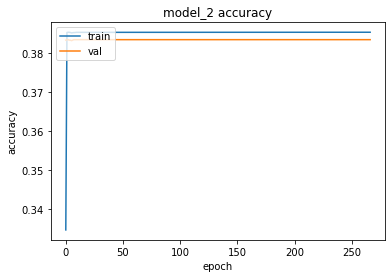

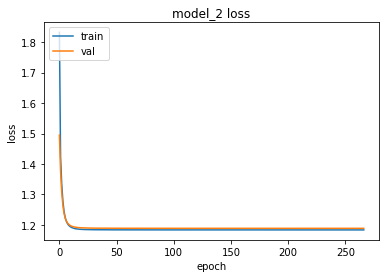

Example predictions...
Input:  [6, 7, 6, 4] Expected: [4, 6, 7, 6] Predicted [6, 6, 6, 6]  False
Input:  [8, 0, 9, 1] Expected: [1, 9, 0, 8] Predicted [9, 9, 9, 9]  False
Input:  [0, 1, 6, 9] Expected: [9, 6, 1, 0] Predicted [1, 1, 1, 1]  False
Input:  [8, 0, 2, 5] Expected: [5, 2, 0, 8] Predicted [8, 8, 8, 8]  False
Input:  [8, 7, 2, 9] Expected: [9, 2, 7, 8] Predicted [2, 2, 2, 2]  False
Input:  [1, 2, 5, 4] Expected: [4, 5, 2, 1] Predicted [4, 4, 4, 4]  False
Input:  [5, 3, 5, 7] Expected: [7, 5, 3, 5] Predicted [5, 5, 5, 5]  False
Input:  [9, 6, 3, 8] Expected: [8, 3, 6, 9] Predicted [8, 8, 8, 8]  False
Input:  [0, 7, 5, 0] Expected: [0, 5, 7, 0] Predicted [0, 0, 0, 0]  False
Input:  [9, 6, 6, 0] Expected: [0, 6, 6, 9] Predicted [6, 6, 6, 6]  False


In [19]:
train_test(lstm_model, X_train, y_train , X_test, y_test, verbose=2)

The accuracy is below 40% for even train data. Thus we need to improve this model by increasing its learning capacity.

In order to increment a model capacity & improve accuracy, in general, we could increment
* number of units
* number of layers
* number of epochs
* number of training samples

We will begin with a model containing multiple LSTM layers which is connected to each other by default output (last hidden states) i.e. the default output (last hidden states) of the first LSTM layer is supplied to the next LSTM layer as inputs!

In [20]:
n_units = 16

model_input = Input(shape=(n_timesteps, n_features))
x = LSTM(16)(model_input)  # First LSTM Layer with default output
x = RepeatVector(n_timesteps)(x)  # Repeat the output of LSTM n_timesteps (4 in our example)

# Second LSTM layer recieves 4 x LSTM outputs as input vector 
# LSTM layer requires 3 dimension input: (batch_size, timesteps, features). Hence, we repeated the output of First LSTM layer
x = LSTM(16)(x)
x = RepeatVector(n_timesteps)(x)
model_output = Dense(n_features, activation='softmax')(x) # Dense layer recieves 4 x LSTM outputs as input vector

lstm_model = Model(model_input, model_output)
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', 
                   metrics=['accuracy'])
lstm_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 4, 10)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                1728      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 4, 16)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                2112      
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 4, 16)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 4, 10)             170       
Total params: 4,010
Trainable params: 4,010
Non-trainable params: 0
_________________________________________________________

training for  500  epochs begins with validation_split = 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/500
563/563 - 4s - loss: 1.7279 - accuracy: 0.3383 - val_loss: 1.4346 - val_accuracy: 0.3801
Epoch 2/500
563/563 - 1s - loss: 1.3686 - accuracy: 0.3833 - val_loss: 1.3260 - val_accuracy: 0.3815
Epoch 3/500
563/563 - 1s - loss: 1.2833 - accuracy: 0.3848 - val_loss: 1.2618 - val_accuracy: 0.3824
Epoch 4/500
563/563 - 2s - loss: 1.2373 - accuracy: 0.3849 - val_loss: 1.2289 - val_accuracy: 0.3832
Epoch 5/500
563/563 - 2s - loss: 1.2155 - accuracy: 0.3853 - val_loss: 1.2143 - val_accuracy: 0.3834
Epoch 6/500
563/563 - 2s - loss: 1.2048 - accuracy: 0.3853 - val_loss: 1.2069 - val_accuracy: 0.3834
Epoch 7/500
563/563 - 1s - loss: 1.1988 - accuracy: 0.3853 - val_loss: 1.2023 - val_accuracy: 0.3834
Epoch 8/500
563/563 - 1s - loss: 1.1950 - accuracy: 0.3853 - val_loss: 1.1989 - val_accuracy: 0.3834
Epoch 9/500
563/563 - 1s - loss: 1.1924 - accuracy: 0.3853 - val_loss: 1.1968 -

Epoch 81/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 82/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 83/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 84/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 85/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 86/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 87/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 88/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 89/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 90/500
563/563 - 2s - loss: 1.1839 - accuracy: 0.3853 - val_loss: 1.1891 - v

Epoch 161/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 162/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 163/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 164/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 165/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 166/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 167/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 168/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1890 - val_accuracy: 0.3834
Epoch 169/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 1.1891 - val_accuracy: 0.3834
Epoch 170/500
563/563 - 2s - loss: 1.1838 - accuracy: 0.3853 - val_loss: 

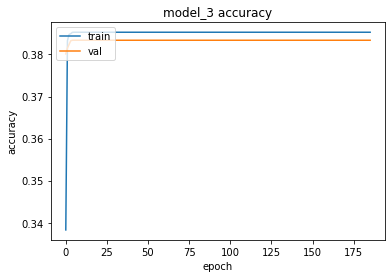

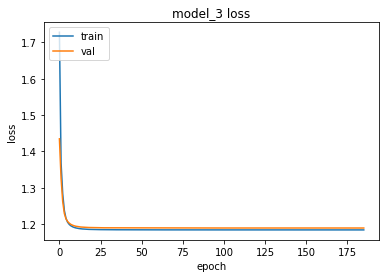

Example predictions...
Input:  [6, 2, 2, 1] Expected: [1, 2, 2, 6] Predicted [2, 2, 2, 2]  False
Input:  [5, 8, 4, 0] Expected: [0, 4, 8, 5] Predicted [8, 8, 8, 8]  False
Input:  [2, 3, 0, 7] Expected: [7, 0, 3, 2] Predicted [7, 7, 7, 7]  False
Input:  [8, 1, 6, 9] Expected: [9, 6, 1, 8] Predicted [6, 6, 6, 6]  False
Input:  [6, 3, 9, 7] Expected: [7, 9, 3, 6] Predicted [6, 6, 6, 6]  False
Input:  [7, 0, 5, 6] Expected: [6, 5, 0, 7] Predicted [7, 7, 7, 7]  False
Input:  [7, 3, 3, 3] Expected: [3, 3, 3, 7] Predicted [3, 3, 3, 3]  False
Input:  [3, 8, 6, 2] Expected: [2, 6, 8, 3] Predicted [2, 2, 2, 2]  False
Input:  [1, 5, 3, 2] Expected: [2, 3, 5, 1] Predicted [3, 3, 3, 3]  False
Input:  [7, 9, 9, 0] Expected: [0, 9, 9, 7] Predicted [9, 9, 9, 9]  False


In [21]:
train_test(lstm_model, X_train, y_train , X_test, y_test, verbose=2)

Test data accuracy (%) did not improve at all. Before trying to increase the capacity of this model, we can use other ways of connecting LSTM layers as follows:

#### 2. LSTM with return_sequences=True output:

Here, we will need to use the TimeDistributed Layer. TimeDistributed Layer allows us to apply the same operation on each time step. For instance, on a video, we may want to apply the same Conv2D on each frame. Then, TimeDistributed layer is used. In Time series, the core idea is the same: we may want to apply an operation on features of each time step. Because it is necessary to keep the time depandancy, we should set **return_sequences=True** before a TimeDistributed layer. 

In [22]:
n_units = 16

model_input = Input(shape=(n_timesteps, n_features))
x = LSTM(16, return_sequences=True)(model_input)  # First LSTM Layer with return_sequences=True

# Output of the first LSTM has 3 dimensions as expected by second LSTM layer. Hence, no RepeatVector is needed.
x = LSTM(16, return_sequences=True)(x)

# Output of the Second LSTM has 3 dimensions. To supply the output to a dense layer, we need to use TimeDistributed layer
model_output = TimeDistributed(Dense(n_features, activation='softmax'))(x) 

lstm_model = Model(model_input, model_output)
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', 
                   metrics=['accuracy'])
lstm_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4, 10)]           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4, 16)             1728      
_________________________________________________________________
lstm_5 (LSTM)                (None, 4, 16)             2112      
_________________________________________________________________
time_distributed (TimeDistri (None, 4, 10)             170       
Total params: 4,010
Trainable params: 4,010
Non-trainable params: 0
_________________________________________________________________


training for  500  epochs begins with validation_split = 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/500
563/563 - 5s - loss: 1.8899 - accuracy: 0.2803 - val_loss: 1.6538 - val_accuracy: 0.3239
Epoch 2/500
563/563 - 1s - loss: 1.5839 - accuracy: 0.3293 - val_loss: 1.5397 - val_accuracy: 0.3314
Epoch 3/500
563/563 - 2s - loss: 1.4993 - accuracy: 0.3573 - val_loss: 1.4763 - val_accuracy: 0.3881
Epoch 4/500
563/563 - 2s - loss: 1.4354 - accuracy: 0.4370 - val_loss: 1.4061 - val_accuracy: 0.4780
Epoch 5/500
563/563 - 1s - loss: 1.3649 - accuracy: 0.5110 - val_loss: 1.3386 - val_accuracy: 0.5295
Epoch 6/500
563/563 - 1s - loss: 1.3047 - accuracy: 0.5389 - val_loss: 1.2859 - val_accuracy: 0.5408
Epoch 7/500
563/563 - 1s - loss: 1.2614 - accuracy: 0.5464 - val_loss: 1.2508 - val_accuracy: 0.5445
Epoch 8/500
563/563 - 1s - loss: 1.2291 - accuracy: 0.5500 - val_loss: 1.2192 - val_accuracy: 0.5493
Epoch 9/500
563/563 - 1s - loss: 1.2047 - accuracy: 0.5505 - val_loss: 1.1982 -

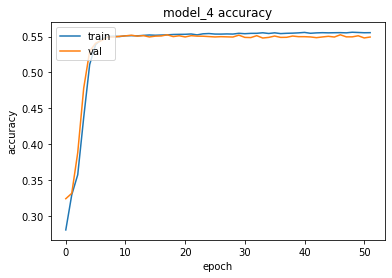

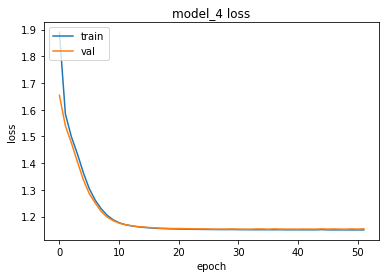

Example predictions...
Input:  [7, 3, 3, 7] Expected: [7, 3, 3, 7] Predicted [9, 8, 3, 7]  False
Input:  [2, 4, 7, 8] Expected: [8, 7, 4, 2] Predicted [2, 0, 4, 2]  False
Input:  [4, 2, 9, 0] Expected: [0, 9, 2, 4] Predicted [6, 4, 2, 4]  False
Input:  [5, 4, 3, 7] Expected: [7, 3, 4, 5] Predicted [4, 4, 4, 5]  False
Input:  [2, 8, 3, 8] Expected: [8, 3, 8, 2] Predicted [2, 2, 8, 2]  False
Input:  [6, 8, 5, 6] Expected: [6, 5, 8, 6] Predicted [9, 4, 8, 6]  False
Input:  [0, 1, 8, 4] Expected: [4, 8, 1, 0] Predicted [9, 6, 1, 0]  False
Input:  [8, 3, 3, 9] Expected: [9, 3, 3, 8] Predicted [2, 3, 3, 8]  False
Input:  [4, 5, 4, 1] Expected: [1, 4, 5, 4] Predicted [6, 3, 5, 4]  False
Input:  [6, 3, 0, 8] Expected: [8, 0, 3, 6] Predicted [9, 6, 3, 6]  False


In [23]:
train_test(lstm_model, X_train, y_train , X_test, y_test, verbose=2)

* Test data Accuracy (%) has improved from 38.34 to 54.94. This tells us that how we connect multiple LSTM layers is important. 
* If we compare the latest model with the previous model it is clear that we are exchanging more information between LSTM layers and also with Dense layers even though the number of parameters are equal.
* In the previous model, we had 16 distinct numbers as the output of the LSTM (i.e. output shape (None, 16)), on the other hand, in the latest model we have 64 (4*16) distinct numbers (i.e. output shape (None, 4, 16)). In the first model, we replicated 16 numbers by 4 times using the RepeatVector layer

Next, we will continue with other ways of connecting LSTM layers.

#### 3. LSTM with return_state=True output:

When return_state=True is set in a LSTM layer, it will return 3 arrays of real numbers:
* LSTM_output (Last Hidden State)
* Last Hidden State (again!)
* Last Cell State (Cell State of the last time step)

We use the 2nd and 3rd outputs of the First LSTM layer to initialize the next LSTM layer’s state = [Last Hidden State + Last Cell State]. Thus, the Second LSTM layer starts with the last state of the First LSTM layer.

As an input for the next LSTM layer, we can use the 1st output [LSTM_output (Last Hidden State)] but since it is 2D (batchsize, features) and the LSTM layer requires 3D (batchsize, timesteps, features) input, we will need to repeat it by timesteps.

In [25]:
n_units = 16

model_input = Input(shape=(n_timesteps, n_features))
x, state_h, state_c = LSTM(16, return_state=True)(model_input)  # First LSTM Layer with return_state=True
states = [state_h, state_c]

x = RepeatVector(n_timesteps)(x)

x = LSTM(16, return_sequences=True)(x, initial_state=states)
model_output = TimeDistributed(Dense(n_features, activation='softmax'))(x)

lstm_model = Model(model_input, model_output)
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', 
                   metrics=['accuracy'])
lstm_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 16), (None,  1728        input_8[0][0]                    
__________________________________________________________________________________________________
repeat_vector_4 (RepeatVector)  (None, 4, 16)        0           lstm_6[0][0]                     
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 4, 16)        2112        repeat_vector_4[0][0]            
                                                                 lstm_6[0][1]               

training for  500  epochs begins with validation_split = 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/500
563/563 - 4s - loss: 1.7314 - accuracy: 0.3543 - val_loss: 1.4089 - val_accuracy: 0.4181
Epoch 2/500
563/563 - 1s - loss: 1.2518 - accuracy: 0.4827 - val_loss: 1.0935 - val_accuracy: 0.5558
Epoch 3/500
563/563 - 1s - loss: 0.9776 - accuracy: 0.6047 - val_loss: 0.8726 - val_accuracy: 0.6519
Epoch 4/500
563/563 - 2s - loss: 0.7944 - accuracy: 0.6897 - val_loss: 0.7206 - val_accuracy: 0.7204
Epoch 5/500
563/563 - 2s - loss: 0.6574 - accuracy: 0.7558 - val_loss: 0.5910 - val_accuracy: 0.7875
Epoch 6/500
563/563 - 1s - loss: 0.5403 - accuracy: 0.8127 - val_loss: 0.4840 - val_accuracy: 0.8366
Epoch 7/500
563/563 - 1s - loss: 0.4408 - accuracy: 0.8563 - val_loss: 0.3949 - val_accuracy: 0.8715
Epoch 8/500
563/563 - 1s - loss: 0.3588 - accuracy: 0.8889 - val_loss: 0.3203 - val_accuracy: 0.9045
Epoch 9/500
563/563 - 1s - loss: 0.2923 - accuracy: 0.9146 - val_loss: 0.2641 -

Epoch 80/500
563/563 - 2s - loss: 3.4928e-04 - accuracy: 1.0000 - val_loss: 4.6588e-04 - val_accuracy: 1.0000
Epoch 81/500
563/563 - 2s - loss: 3.2222e-04 - accuracy: 1.0000 - val_loss: 5.0409e-04 - val_accuracy: 1.0000
Epoch 82/500
563/563 - 2s - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.0013 - val_accuracy: 0.9999
Epoch 83/500
563/563 - 2s - loss: 5.6156e-04 - accuracy: 1.0000 - val_loss: 7.0703e-04 - val_accuracy: 1.0000
Epoch 84/500
563/563 - 2s - loss: 4.0413e-04 - accuracy: 1.0000 - val_loss: 5.6974e-04 - val_accuracy: 1.0000
Epoch 85/500
563/563 - 2s - loss: 3.4807e-04 - accuracy: 1.0000 - val_loss: 4.7657e-04 - val_accuracy: 1.0000
Epoch 86/500
563/563 - 2s - loss: 3.1299e-04 - accuracy: 1.0000 - val_loss: 4.5157e-04 - val_accuracy: 1.0000
Epoch 87/500
563/563 - 2s - loss: 2.9274e-04 - accuracy: 1.0000 - val_loss: 3.9382e-04 - val_accuracy: 1.0000
Epoch 88/500
563/563 - 2s - loss: 2.7076e-04 - accuracy: 1.0000 - val_loss: 4.4626e-04 - val_accuracy: 1.0000
Epoch 89/500
563/5

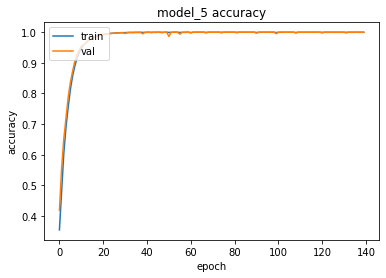

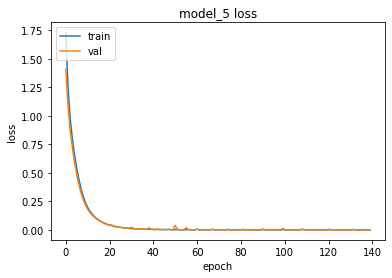

Example predictions...
Input:  [2, 5, 2, 6] Expected: [6, 2, 5, 2] Predicted [6, 2, 5, 2]  True
Input:  [2, 2, 9, 7] Expected: [7, 9, 2, 2] Predicted [7, 9, 2, 2]  True
Input:  [2, 6, 8, 7] Expected: [7, 8, 6, 2] Predicted [7, 8, 6, 2]  True
Input:  [9, 5, 6, 5] Expected: [5, 6, 5, 9] Predicted [5, 6, 5, 9]  True
Input:  [0, 6, 8, 8] Expected: [8, 8, 6, 0] Predicted [8, 8, 6, 0]  True
Input:  [4, 1, 8, 1] Expected: [1, 8, 1, 4] Predicted [1, 8, 1, 4]  True
Input:  [7, 5, 5, 0] Expected: [0, 5, 5, 7] Predicted [0, 5, 5, 7]  True
Input:  [4, 1, 5, 1] Expected: [1, 5, 1, 4] Predicted [1, 5, 1, 4]  True
Input:  [6, 3, 0, 1] Expected: [1, 0, 3, 6] Predicted [1, 0, 3, 6]  True
Input:  [4, 2, 1, 8] Expected: [8, 1, 2, 4] Predicted [8, 1, 2, 4]  True


In [26]:
train_test(lstm_model, X_train, y_train , X_test, y_test, verbose=2)

* Test data Accuracy (%) has massively improved from 38.34 & 54.94 to 100!. (This exceeds our expectations even...)
* If we compare the latest model with the previous models it is clear that we are exchanging more information between LSTM layers even though the number of parameters is the same!
* In the latest model, we do not only provide the output of the previous LSTM layer to the next one, but we also provide the last state of the previous LSTM layer to the next LSTM layer as the initial state!
* In the previous models, we had only provided inputs to the next layer, on the other hand, in the latest model we have also provided initial values for hidden and cell states of the next LSTM layer.

We are still replicating the hidden states 4 times using the RepeatVector layer! In the next model, we will change what we provide as an input to the next layer.

#### 4. LSTM with return_state=True and return_sequences=True output

In LSTMs, when return_sequences=True & return_state=True is set, it will return 3 arrays of real numbers:
* All Hidden States (Hidden State of ALL the time steps)
* Last Hidden State (Hidden State of the last time step)
* Last Cell State (Cell State of the last time step)

As an input for the next LSTM layer, we can use the 1st output [All Hidden States] and since it is 3D (batchsize, timesteps, features) in shape, we do not need to use RepeatVector as we did in the previous model.

The second and the third outputs will be used as the initial states to the Second LSTM layer.

In [27]:
n_units = 16

model_input = Input(shape=(n_timesteps, n_features))
x, state_h, state_c = LSTM(16, return_sequences=True, return_state=True)(model_input)  # First LSTM Layer with return_state=True
states = [state_h, state_c]

x = LSTM(16, return_sequences=True)(x, initial_state=states)
model_output = TimeDistributed(Dense(n_features, activation='softmax'))(x)

lstm_model = Model(model_input, model_output)
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', 
                   metrics=['accuracy'])
lstm_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 4, 16), (Non 1728        input_9[0][0]                    
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 4, 16)        2112        lstm_8[0][0]                     
                                                                 lstm_8[0][1]                     
                                                                 lstm_8[0][2]                     
____________________________________________________________________________________________

training for  500  epochs begins with validation_split = 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/500
563/563 - 4s - loss: 1.6948 - accuracy: 0.3686 - val_loss: 1.3095 - val_accuracy: 0.4490
Epoch 2/500
563/563 - 1s - loss: 1.1158 - accuracy: 0.5364 - val_loss: 0.9714 - val_accuracy: 0.5959
Epoch 3/500
563/563 - 1s - loss: 0.8482 - accuracy: 0.6563 - val_loss: 0.7492 - val_accuracy: 0.7088
Epoch 4/500
563/563 - 2s - loss: 0.6530 - accuracy: 0.7537 - val_loss: 0.5728 - val_accuracy: 0.7945
Epoch 5/500
563/563 - 1s - loss: 0.4986 - accuracy: 0.8272 - val_loss: 0.4420 - val_accuracy: 0.8581
Epoch 6/500
563/563 - 1s - loss: 0.3785 - accuracy: 0.8829 - val_loss: 0.3290 - val_accuracy: 0.9065
Epoch 7/500
563/563 - 1s - loss: 0.2810 - accuracy: 0.9236 - val_loss: 0.2412 - val_accuracy: 0.9367
Epoch 8/500
563/563 - 1s - loss: 0.2040 - accuracy: 0.9515 - val_loss: 0.1721 - val_accuracy: 0.9649
Epoch 9/500
563/563 - 1s - loss: 0.1470 - accuracy: 0.9705 - val_loss: 0.1231 -

Epoch 77/500
563/563 - 2s - loss: 4.1705e-05 - accuracy: 1.0000 - val_loss: 5.0785e-05 - val_accuracy: 1.0000
Epoch 78/500
563/563 - 1s - loss: 3.5930e-05 - accuracy: 1.0000 - val_loss: 4.5006e-05 - val_accuracy: 1.0000
Epoch 79/500
563/563 - 2s - loss: 3.1415e-05 - accuracy: 1.0000 - val_loss: 4.1597e-05 - val_accuracy: 1.0000
Epoch 80/500
563/563 - 2s - loss: 2.7788e-05 - accuracy: 1.0000 - val_loss: 3.6472e-05 - val_accuracy: 1.0000
Epoch 81/500
563/563 - 2s - loss: 2.4752e-05 - accuracy: 1.0000 - val_loss: 3.3451e-05 - val_accuracy: 1.0000
Epoch 82/500
563/563 - 2s - loss: 2.2141e-05 - accuracy: 1.0000 - val_loss: 2.9041e-05 - val_accuracy: 1.0000
Epoch 83/500
563/563 - 2s - loss: 1.9902e-05 - accuracy: 1.0000 - val_loss: 2.6519e-05 - val_accuracy: 1.0000
Epoch 84/500
563/563 - 2s - loss: 1.7983e-05 - accuracy: 1.0000 - val_loss: 2.4523e-05 - val_accuracy: 1.0000
Epoch 85/500
563/563 - 2s - loss: 1.6127e-05 - accuracy: 1.0000 - val_loss: 2.1577e-05 - val_accuracy: 1.0000
Epoch 86/5

563/563 - 2s - loss: 4.5270e-06 - accuracy: 1.0000 - val_loss: 9.1689e-06 - val_accuracy: 1.0000
Epoch 152/500
563/563 - 2s - loss: 3.9252e-06 - accuracy: 1.0000 - val_loss: 7.7778e-06 - val_accuracy: 1.0000
Epoch 153/500
563/563 - 2s - loss: 3.4116e-06 - accuracy: 1.0000 - val_loss: 6.9021e-06 - val_accuracy: 1.0000
Epoch 154/500
563/563 - 2s - loss: 2.9690e-06 - accuracy: 1.0000 - val_loss: 5.9174e-06 - val_accuracy: 1.0000
Epoch 155/500
563/563 - 2s - loss: 2.5906e-06 - accuracy: 1.0000 - val_loss: 5.1247e-06 - val_accuracy: 1.0000
Epoch 156/500
563/563 - 2s - loss: 2.2691e-06 - accuracy: 1.0000 - val_loss: 4.5017e-06 - val_accuracy: 1.0000
Epoch 157/500
563/563 - 2s - loss: 1.9902e-06 - accuracy: 1.0000 - val_loss: 3.9955e-06 - val_accuracy: 1.0000
Epoch 158/500
563/563 - 2s - loss: 1.7528e-06 - accuracy: 1.0000 - val_loss: 3.4720e-06 - val_accuracy: 1.0000
Epoch 159/500
563/563 - 2s - loss: 1.5514e-06 - accuracy: 1.0000 - val_loss: 3.0599e-06 - val_accuracy: 1.0000
Epoch 160/500
5

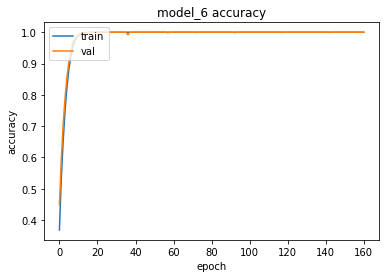

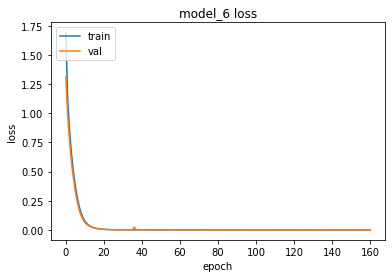

Example predictions...
Input:  [3, 1, 0, 5] Expected: [5, 0, 1, 3] Predicted [5, 0, 1, 3]  True
Input:  [9, 5, 5, 4] Expected: [4, 5, 5, 9] Predicted [4, 5, 5, 9]  True
Input:  [8, 4, 9, 8] Expected: [8, 9, 4, 8] Predicted [8, 9, 4, 8]  True
Input:  [2, 1, 1, 6] Expected: [6, 1, 1, 2] Predicted [6, 1, 1, 2]  True
Input:  [9, 4, 6, 8] Expected: [8, 6, 4, 9] Predicted [8, 6, 4, 9]  True
Input:  [6, 1, 3, 6] Expected: [6, 3, 1, 6] Predicted [6, 3, 1, 6]  True
Input:  [2, 5, 9, 7] Expected: [7, 9, 5, 2] Predicted [7, 9, 5, 2]  True
Input:  [5, 6, 7, 1] Expected: [1, 7, 6, 5] Predicted [1, 7, 6, 5]  True
Input:  [3, 4, 0, 6] Expected: [6, 0, 4, 3] Predicted [6, 0, 4, 3]  True
Input:  [3, 9, 6, 5] Expected: [5, 6, 9, 3] Predicted [5, 6, 9, 3]  True


In [28]:
train_test(lstm_model, X_train, y_train , X_test, y_test, verbose=2)

As expected, the accuracy on the test data is 100 which is great news!

In the latest model, we have provided:
* previous LSTM’s last hidden and cell states as initial values to the next LSTM layer’s hidden and cell states.
* previous LSTM’s all hidden states as inputs to the next LSTM layer

In other words, second LSTM layer:
* starts to operate with the last hidden states and cell states of the first LSTM layer
* consumes the first LSTM layer’s all hidden states to produce the output

As a result, during training:
* The second LSTM layer is conditioned to produce expected outputs given the first LSTM layer’s outputs.
* The first LSTM layer is conditioned to produce such outputs that the second LSTM layer would be successful in prediction.

Thus:
* We can argue that the first LSTM layer encodes the input (X) in a representation that the second LSTM layer can decode it to produce the expected output (y)
* The encoded representation of the input (X) in the last model is composed of the all hidden states + last hidden + cell states


#### Now a few questions that might arise:
* When n_timesteps is 4, the model is able to achieve 97.3% accuracy
* What if we set n_timesteps to 8?
* What if we set n_timesteps to 16?

Actually, the performance of the models starts to decrease when we request them to deal with longer sequences. So, how to handle longer sequences?

A generic Solution would be to increment the model capacity!

In order to increment a model capacity & improve accuracy, we could
* increment number of units
* increment number of layers
* increment number of epochs
* increment number of training samples

However, even the length of the input sequence is increased a little bit (e.g. from 4 to 8) and the model can not catch up with it to provide similar accuracy applying all the above measures.

So in conclusion, LSTM layers cannot handle/remember/relate longer sequences. 

#### A few more questions can arise:
* How can we create a model to handle variable-length input/output? Here all the inputs and outputs already had a fixed length.
* How can you train such a model?

One alternative we can think of is that we can use padding (i.e. adding some special symbol (e.g. zero) in front of or at the end of each sequence such that all sequences have an equal length with the maximum sequence length in the dataset).

However, there are plenty of drawbacks to this solution:
* Waste of space and computation power
* In real life, sometimes we do NOT know the maximum sequence length
* In some applications, the input sequence is continuous (e.g. speech recognition). Thus, we cannot wait until the end of the sequence to process (i.e. padding) it!

So, we would maybe need a better alternative model architecture to mitigate all these drawbacks.

### Basic Encoder-Decoder Architecture

#### Why do we need a new architecture/design?
* So far, we first train a model then use that trained model in prediction
* However, this approach assumes that input and/or output sizes are fixed, known in advance, and not continous
* Moreover, this approach is not good at handling longer sequences
* Furthermore, this approach needs more resources (more data, more training, more layers, etc.) to discover even the simple seq2seq relations

#### What are we looking for in new design?
* A flexible train and predict/inference process
* Model should handle variable size of input/output
* Seq2Seq conversion should be done with reasonable resources and with high accuracy
* Model should be scalable in terms of input/output size (long sequences)

We have two main components working together in the Encoder-Decoder model:
* Encoder encodes the sequence input into a new representation. This representation is called Context/Thought Vector
* Decoder decodes the Context/Thought Vector into output sequence

![title](assets/AE.png)

Here we will be using LSTM as the Recurrent Neural Network. 

#### Things to note:
* **Training**: During training, we train the encoder and decoder such that they work together to create a context (representation) between input and output
* **Inference (Prediction)**: After learning how to create the context (representation), they can work together to predict the output
* **Encode all- decode one at a time**: Mostly, encoder reads all the input sequence and create a context (representation) vector. Decoder use this context (representation) vector and previously decoded result to create new output step by step.
* **Teacher forcing**: During training, decoder receives the correct output from the training set as the previously decoded result to predict the next output. However, during inference decoder receives the previously decoded result to predict the next output. Teacher forcing improves training process.

#### Understanding & applying context vector

Context vector is
* the encoded version of the input sequence
* the new representation of the input sequence
* the summary of the input sequence
* the last (hidden & cell) states of the encoder
* the initial (hidden & cell) states of the decoder But,
* NOT the output of the encoder

Therefore, in the encoder LSTM, we will use return_state=True for getting the last Hidden and Cell states.

![TITLE](assets/lstm_AE.png)

We will need to decide the context (latent) vector dimension:
* Actually it is the number of LSTM units parameter of the LSTM layer in Keras.
* As the context vector is the condensed representation of the whole input sequence mostly we prefer a large dimension.
* We can increment the context (latent) vector dimension by 2 ways:
    * increment the number of units in encoder LSTM
    * and/or increment the number of encoder LSTM layers
* For the sake of simplicity, we use single LSTM layer in encoder and decoder layers for the time being

In [45]:
def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5, verbose=0):
    
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
    
    # train model
    print('training for ', epochs, ' epochs begins with EarlyStopping while monitoring val_loss...')
    history = model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs, 
                        batch_size=batch_size, verbose=verbose, callbacks=[es])
    print(epochs,' epoch training finished...')


    # evaluate model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    
    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model.name+' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model.name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # spot check some examples
    space = 3 * len(one_hot_decode(y_test[0]))
    print('10 examples from test data...')
    print('Input',' '*(space-4) ,'Expected',' '*(space-7) ,
          'Predicted',' '*(space-5) ,'T/F')
    correct = 0 
    sampleNo = 10

    predicted = model_encoder_decoder.predict(X_test[:sampleNo], batch_size=batch_size)
    for sample in range(0,sampleNo):
        if (one_hot_decode(y_test[sample]) == one_hot_decode(predicted[sample])):
            correct += 1
        print(one_hot_decode(X_test[sample]), ' ', 
              one_hot_decode(y_test[sample]), ' ', 
              one_hot_decode(predicted[sample]), ' ',
              one_hot_decode(y_test[sample]) == one_hot_decode(predicted[sample]))
    print('Accuracy: ', correct/sampleNo)

In [14]:
n_units = 16 # Output dimensions of the encoder

# Define the encoder layers
encoder_inputs = Input(shape=(n_timesteps, n_features), name='encoder_inputs')
encoder_lstm = LSTM(n_units, return_state=True,  name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
states = [state_h, state_c]
model_encoder = Model(encoder_inputs, states) 
context_vector = model_encoder(X)

"""
The dimension of each state equals to the LSTM unit number (n_units).

Context vector generally is [state_h , state_c]. In the LSTM, these 
values are actually the last states of the encoder LSTM.
"""

print('X.shape: ', X.shape)
print('n_lstm_units: ', n_units)
print('last hidden states.shape', context_vector[0].numpy().shape)
print('last cell states.shape', context_vector[1].numpy().shape)

X.shape:  (1, 4, 10)
n_lstm_units:  16
last hidden states.shape (1, 16)
last cell states.shape (1, 16)


In [15]:
# Set up the decoder, which will only process one timestep at a time.
decoder_inputs = Input(shape=(1, n_features), name='decoder_inputs')
decoder_lstm = LSTM(n_units, return_sequences=True, 
                    return_state=True, name='decoder_lstm')
decoder_dense = Dense(n_features, activation='softmax')


outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=states)
decoder_lstm.output_shape

[(None, 1, 16), (None, 16), (None, 16)]

Now decoder is ready to process the data: BUT WHICH DATA?
* Input data is already consumed by Encoder and converted into a context vector.
* Context vector is already consumed as initial states of the decoder (LSTM)
* So what is the input for decoder?
* Remember the problem: reversing the input sequence. So we have input X and output y which is the reverse sequence of X

### How Encoder - Decoder would work in inference

We need 2 input sequences:
* Input for encoder: encoder_inputs
* Input for decoder: decoder_inputs

The encoder_inputs is given in the problem as a sequence. We will supply them directly to the Encoder.


#### Encoder:
* Receives the input sequence
* It consumes the tokens at each time steps
* After finishing all tokens in the input sequence, Encoder outputs last hidden & cell states as the context vector.
* Encoder stops

#### Decoder:
* Decoder produce the output sequece one by one
* For each output, the decoder consumes a context vector and an input
* The initial context vector is created by the encoder
* The initial input to the decoder is a special symbol for decoder to make it start, e.g. ‘zero’
* Using initial context and initial input, the decoder will generate/predict the first output
* For the next time step, decoder will use its own last hidden & cell states as context vector and generated/predicted output at the previous time step as input
* Decoder will work in such a loop using its states and output as the next step context vector and input until:
    * the generated output is a special symbol (e.g. ‘STOP’ or ‘END’) or
    * the pre-defined maximum steps (length of output) is reached.
    
### Approaching the problem:
* In the reversing input sequence problem of outs, input & output sequence lengths are fixed and same. We have n_timesteps tokens in input & output sequences.
* Therefore, the decoder in our solution will stop after producing pre-determined number of tokens (outputs). That is, we do not need ‘STOP’ or ‘END’ symbol in this problem.
* However, decoder will begin to work with ‘START’ symbol. We reserve the 0 (zero) as the ‘START’ symbol. Therefore, we DID NOT use 0 (zero) as a token while creating sequence samples.
* In summary, we will condition the decoder to start with context vector and ‘START’ symbol to predict output sequence as many as n_timesteps parameter.

#### 1. Encoder Decoder Model

#### Encoder:
* receives the input sequence
* consumes the tokens at each time steps
* outputs last hidden & cell states as the context vector after finishing all tokens in the input sequence stops
* For decoder_inputs we will provide ‘START’ token as the initial input.

#### Decoder:
* predicts the first time step ouput consuming the context vector provided by Encoder and initial input.
* consumes the predicted output as the next input, its previous last hidden & cell states as the context vector for the next time steps
* stops when the required number of tokens outputed, since, in our problem, input and output sequences have fixed and same sizes

#### Flow of Encoder-Decoder Model:
* Encoder receives encoder input data and converts it to a context vector
* Decoder runs in a loop.
* Decoder is initialized with context vector and recives decoder input data
* Decoder converts decoder input data to one time step output
* Decoder also outputs its hidden states and cell states as context vector
* In the next cycle of the loop, decoder use its states and output as the input for itself (the context vector and the input)

In [17]:
def get_encoder_decoder(batch_size):
  
    # Encoder Layers
    encoder_inputs = Input(shape=(n_timesteps, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(n_units, return_state=True,  name='encoder_lstm')
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
    
    # initial context vector is the states of the encoder
    states = [state_h, state_c]
  
    # Decoder layers
    # NOTE: decoder receives 1 token at a time & outputs 1 token at a time 
    decoder_inputs = Input(shape=(1, n_features))
    decoder_lstm = LSTM(n_units, return_sequences=True, 
                        return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')

    all_outputs = []
    # Prepare decoder initial input data: just contains the START character 0
    # Note that we made it a constant one-hot-encoded sequence in the model
    decoder_input_data = np.zeros((batch_size, 1, n_features))
    decoder_input_data[:, 0, 0] = 1 
  
    # i.e., [1 0 0 0 0 0 0 0 0 0] is the initial input for each loop
    inputs = decoder_input_data
    
    # decoder will only process one time step at a time
    # loops for fixed number of time steps: n_timesteps
    for _ in range(n_timesteps):
        # Run the decoder on one time step
        outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
        outputs = decoder_dense(outputs)
        
        # Store the current prediction (we will concatenate all predictions later)
        all_outputs.append(outputs)
        
        # Reinject the outputs as inputs for the next loop iteration as well as update the states
        inputs = outputs
        states = [state_h, state_c]

    # Concatenate all predictions such as [batch_size, timesteps, features]
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

    # Define and compile model 
    model = Model(encoder_inputs, decoder_outputs, name='encoder-decoder-model')
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
batch_size = 10
model_encoder_decoder = get_encoder_decoder(batch_size=batch_size)
model_encoder_decoder.summary()
# plot_model(model_encoder_decoder, show_shapes=True)

Model: "encoder-decoder-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 16), (None,  1728        encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(10, 1, 16), (None, 1728        encoder_lstm[0][1]               
                                                                 encoder_lstm[0][2]               
                                                                 decoder_dense[0][0]              
                                                                 decoder_lstm[

training for  500  epochs begins with EarlyStopping while monitoring val_loss...


2021-10-19 12:59:29.345822: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-19 12:59:29.489056: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1999965000 Hz


Epoch 1/500
1800/1800 [==============================] - 12s 4ms/step - loss: 1.8469 - accuracy: 0.3226 - val_loss: 1.2097 - val_accuracy: 0.4913
Epoch 2/500
1800/1800 [==============================] - 5s 3ms/step - loss: 1.0564 - accuracy: 0.5620 - val_loss: 0.5379 - val_accuracy: 0.8311
Epoch 3/500
1800/1800 [==============================] - 5s 3ms/step - loss: 0.3834 - accuracy: 0.8916 - val_loss: 0.1063 - val_accuracy: 0.9847
Epoch 4/500
1800/1800 [==============================] - 5s 3ms/step - loss: 0.0821 - accuracy: 0.9893 - val_loss: 0.0326 - val_accuracy: 0.9973
Epoch 5/500
1800/1800 [==============================] - 5s 3ms/step - loss: 0.0235 - accuracy: 0.9984 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 6/500
1800/1800 [==============================] - 5s 3ms/step - loss: 0.0076 - accuracy: 0.9996 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 7/500
1800/1800 [==============================] - 5s 3ms/step - loss: 0.0027 - accuracy: 0.9999 - val_loss: 0.0014 - val_a

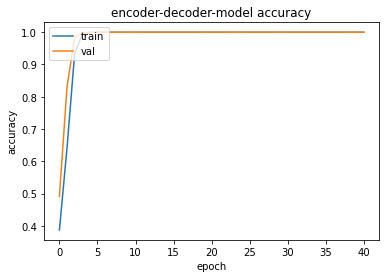

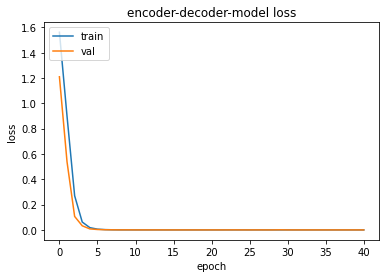

10 examples from test data...
Input          Expected       Predicted         T/F
[0, 3, 8, 0]   [0, 8, 3, 0]   [0, 8, 3, 0]   True
[6, 7, 1, 5]   [5, 1, 7, 6]   [5, 1, 7, 6]   True
[2, 9, 2, 3]   [3, 2, 9, 2]   [3, 2, 9, 2]   True
[6, 8, 5, 9]   [9, 5, 8, 6]   [9, 5, 8, 6]   True
[6, 4, 6, 8]   [8, 6, 4, 6]   [8, 6, 4, 6]   True
[2, 7, 4, 4]   [4, 4, 7, 2]   [4, 4, 7, 2]   True
[4, 8, 4, 6]   [6, 4, 8, 4]   [6, 4, 8, 4]   True
[7, 7, 1, 9]   [9, 1, 7, 7]   [9, 1, 7, 7]   True
[0, 5, 9, 1]   [1, 9, 5, 0]   [1, 9, 5, 0]   True
[6, 2, 6, 9]   [9, 6, 2, 6]   [9, 6, 2, 6]   True
Accuracy:  1.0


In [24]:
train_test(model_encoder_decoder, X_train, y_train, 
           X_test, y_test, batch_size=batch_size, epochs=500, verbose=1)

The accuracy and loss metrics are more than enough to solve our problem.

Next, we will try and improve the training process of the Encoder Decoder model by implementing Teacher Forcing.

#### 2. Encoder-Decoder model with teacher forcing

The initial steps for this model are the same:
* Decoder produces the output sequence one by one
* For each output, the decoder consumes a context vector and an input
* The initial context vector is created by the encoder
* The initial input is a special symbol for the decoder to make it start, e.g. ‘start’
* Using initial context and initial input, the decoder will generate the first output

However, the input to the decoder during the loop is different. For the next output,
* the decoder will use its current state as context vector and generated (predicted) output as input
* we (the teacher!) provide the correct output to the decoder as input
* The difference is: decoder use the context vector and the correct input to the next output rather than using its prediction in the previous cycle
* The decoder will work in such a loop using its state and output provided correct output as the next step context vector and input until the generated output is a special symbol ‘stop’ or the pre-defined maximum steps (length of output) is reached.


Therefore, we need to provide 2 input sequences to train an Encoder-Decoder model with teacher forcing such that:

* input to encoder: [4 7 2 8]
* input to decoder: [0 8 2 7]

Note that:
* The expected output is [8 2 7 4] — — reverse of input to the encoder
* 0 (zero) is selected as a special symbol for ‘start’
* input to decoder is created by shifting the expected output by one time steps and adding ‘start’ token as the first token: [8 2 7 4] — — → [0 8 2 7]

![Title](assets/AE_teacher_forcing.png)

#### Flow of Encoder-Decoder Model with Teacher Forcing:

#### During Training:
* At the first cycle, the decoder will use the encoder’s state and its first input which is 0 from decoder input sequence [0 8 2 7] to generate the first output which is expected to be 8 from [8 2 7 4]
* Assume that decoder predicts 7
* In the generic Encoder-Decoder model, the decoder will use 7 to generate/predict the next token
* In teacher forcing, we (the teacher!) provide the second input from [0 8 2 7] which is 8 to the decoder to generate/predict the next token
* Thus, during training, the teacher enforces the decoder to condition itself to generate/predict the next token according to the given correct input!

#### During Inference:
<!-- We need 2 input sequences:
* Input for encoder: encoder_inputs
* Input for decoder: decoder_inputs -->

The encoder_inputs is given
* However, this time we do not have correct outputs
* Therefore, we will provide the predicted output as the input.
* The first input is ‘start’ and the other inputs will be the outputs from the previous cycle

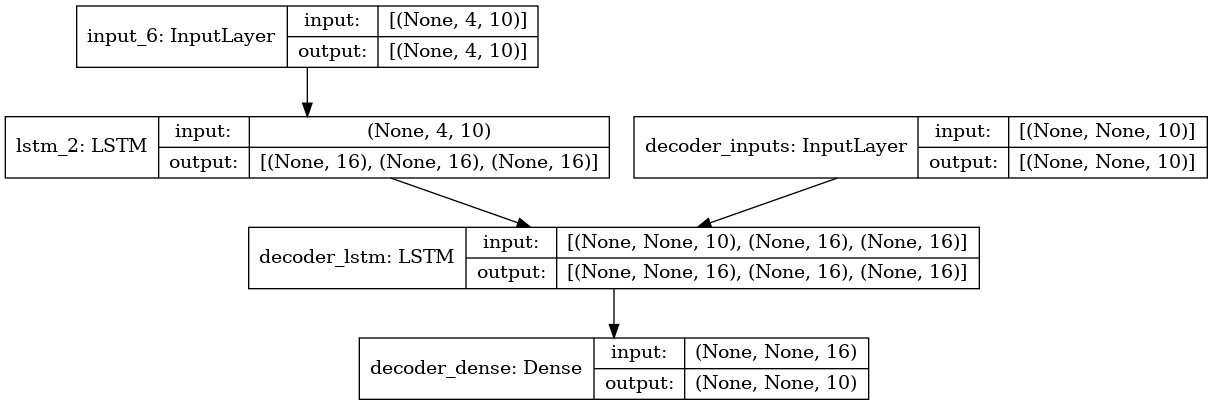

In [52]:
    
# Define an input sequence and process it.
encoder_inputs = Input(shape=(n_timesteps, n_features))
encoder_lstm = LSTM(n_units, return_state=True)
LSTM_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# We discard `LSTM_outputs` and only keep the other states.
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, n_features), name='decoder_inputs')
decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, name='decoder_lstm')

# Set up the decoder, using `context vector` as initial state.
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

# Complete the decoder model by adding a Dense layer with Softmax activation function 
# for prediction of the next output
# Dense layer will output one-hot encoded representation as we did for input
# Therefore, we will use n_features number of neurons
decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# put together
model_encoder_decoder_tf = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='model_encoder_training')
model_encoder_decoder_tf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_model(model_encoder_decoder_tf, show_shapes=True)

To train the Encoder-Decoder model we need to work on the train data set such that we will prepare 3 data sets:
1. **Input for encoder (encoder_inputs)**: all sequence of 1 sample training input data (X)
2. **Input for the decoder (decoder_inputs)**: 1 token from 1 sample training target sequence (y) for teacher forcing [should start with ‘start’ symbol]
3. **Target for decoder (decoder_predicted_data)**: 1 token from 1 sample training target sequence (y) [should end with ‘end’ symbol]

We can modify the code such that the first number (0) of the input domain numbers are reserved for ‘start’ and ‘end’ symbols.

In [42]:
# generate a sequence of random integers
def generate_sequence(length, n_unique):
    return [randint(1, n_unique-1) for _ in range(length)]


# one hot encode sequence
def one_hot_encode(sequence, n_unique):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)


# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]


# prepare encoder data for the Encoder-Decoder training
def get_encoder_triple(time_steps,vocabulary_size,verbose= False):
    # generate random sequence
    sequence_in = generate_sequence(time_steps, vocabulary_size)

    encoder_in = sequence_in.copy()
    decoder_out = sequence_in[::-1]
  
    decoder_in = decoder_out.copy()
    decoder_in.insert(0,0)
    decoder_in.pop()

    # one hot encode
    X_encoder_in = one_hot_encode(encoder_in, vocabulary_size)
    X_decoder_in = one_hot_encode(decoder_in, vocabulary_size)
    y_decoder_out = one_hot_encode(decoder_out, vocabulary_size)
    
    # reshape as 3D
    X_encoder_in = X_encoder_in.reshape((1, X_encoder_in.shape[0], X_encoder_in.shape[1]))
    X_decoder_in = X_decoder_in.reshape((1, X_decoder_in.shape[0], X_decoder_in.shape[1]))
    y_decoder_out = y_decoder_out.reshape((1, y_decoder_out.shape[0], y_decoder_out.shape[1]))

    if(verbose):
        print('\nSample X_encoder_in X_decoder_in and y_decoder_out')
        print('\nIn raw format:')
        print('X_encoder_in=%s, X_decoder_in=%s, y_decoder_out=%s' % 
              (one_hot_decode(X_encoder_in[0]), one_hot_decode(X_decoder_in[0]), 
               one_hot_decode(y_decoder_out[0])))
        print('\nIn one_hot_encoded format:')
        print('X_encoder_in=%s' % (X_encoder_in[0]))
        print('X_decoder_in=%s' % (X_decoder_in[0]))
        print('y_decoder_out=%s' % (y_decoder_out[0]))
    return [np.array(X_encoder_in), np.array(X_decoder_in), np.array(y_decoder_out)]


def create_encoder_dataset(train_size, test_size, time_steps,vocabulary_size, verbose= False):

    X_encoder_in = list()
    X_decoder_in = list()
    y_decoder_out = list()

    for _ in range(train_size):
        triple = get_encoder_triple(time_steps,vocabulary_size) 
        X_encoder_in.append(triple[0])
        X_decoder_in.append(triple[1])
        y_decoder_out.append(triple[2])

    X_encoder_in = np.array(X_encoder_in).squeeze()
    X_decoder_in = np.array(X_decoder_in).squeeze()
    y_decoder_out = np.array(y_decoder_out).squeeze()
    if(verbose):
        print('\nGenerated sequence datasets as follows')
        print('X_encoder_in.shape: ', X_encoder_in.shape)
        print('X_decoder_in.shape: ', X_decoder_in.shape)
        print('y_decoder_out.shape: ', y_decoder_out.shape)
        print('Sample sequences in raw format:')

        print('X_encoder_in: \n', one_hot_decode(X_encoder_in[0]))
        print('X_decoder_in: \n', one_hot_decode(X_decoder_in[0]))
        print('y_decoder_out: \n',one_hot_decode(y_decoder_out[0]))

        print('Sample sequences in one-hot encoded format:')
        print('X_encoder_in: \n', X_encoder_in[0])
        print('X_decoder_in: \n', X_decoder_in[0])
        print('y_decoder_out: \n', y_decoder_out[0])

    return X_encoder_in, X_decoder_in, y_decoder_out

In [43]:
n_timesteps = 4 # each input sample has 4 values


n_features = 10   # each value is one_hot_encoded with 10 0/1

# generate datasets
train_size= 5000 # size of train_data
test_size = 100  # size of test_data

encoder_input_data, decoder_input_data, decoder_predicted_data = create_encoder_dataset(train_size, test_size, 
                                                                                        n_timesteps, n_features, 
                                                                                        verbose=True)


Generated sequence datasets as follows
X_encoder_in.shape:  (5000, 4, 10)
X_decoder_in.shape:  (5000, 4, 10)
y_decoder_out.shape:  (5000, 4, 10)
Sample sequences in raw format:
X_encoder_in: 
 [4, 5, 8, 6]
X_decoder_in: 
 [0, 6, 8, 5]
y_decoder_out: 
 [6, 8, 5, 4]
Sample sequences in one-hot encoded format:
X_encoder_in: 
 [[0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0]]
X_decoder_in: 
 [[1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0]]
y_decoder_out: 
 [[0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


In [5]:
def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5, verbose=0):

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

    # train model
    print('training for ',epochs,' training for  50  epochs begins with EarlyStopping while monitoring val_loss...')
    history = model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,batch_size=batch_size, verbose=verbose, callbacks=[es])
    print(epochs,' epoch training finished...')

    # evaluate model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model.name+' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model.name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # spot check some examples
    space = 3*len(one_hot_decode(y_test[0]))
    print('10 examples from test data...')
    print('Input',' '*(space-4) ,'Expected',' '*(space-7) ,
          'Predicted',' '*(space-5) ,'T/F')
    correct = 0 
    sampleNo =  10

    predicted = model.predict(X_test[:sampleNo], batch_size=batch_size)
    for sample in range(0, sampleNo):
        if (one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample])):
            correct += 1
        print(one_hot_decode(X_test[0][sample]), ' ', 
              one_hot_decode(y_test[sample]), ' ', 
              one_hot_decode(predicted[sample]), ' ',
              one_hot_decode(y_test[sample]) == one_hot_decode(predicted[sample]))
    print('Accuracy: ', correct/sampleNo)

training for  50  training for  50  epochs begins with EarlyStopping while monitoring val_loss...
Epoch 1/50
141/141 - 3s - loss: 2.1681 - accuracy: 0.2157 - val_loss: 1.9384 - val_accuracy: 0.3140
Epoch 2/50
141/141 - 0s - loss: 1.6865 - accuracy: 0.3990 - val_loss: 1.4882 - val_accuracy: 0.4600
Epoch 3/50
141/141 - 0s - loss: 1.2418 - accuracy: 0.5532 - val_loss: 1.0510 - val_accuracy: 0.6600
Epoch 4/50
141/141 - 0s - loss: 0.8669 - accuracy: 0.7614 - val_loss: 0.7194 - val_accuracy: 0.8600
Epoch 5/50
141/141 - 0s - loss: 0.5902 - accuracy: 0.8974 - val_loss: 0.4878 - val_accuracy: 0.9315
Epoch 6/50
141/141 - 0s - loss: 0.4068 - accuracy: 0.9557 - val_loss: 0.3444 - val_accuracy: 0.9705
Epoch 7/50
141/141 - 0s - loss: 0.2923 - accuracy: 0.9775 - val_loss: 0.2530 - val_accuracy: 0.9820
Epoch 8/50
141/141 - 0s - loss: 0.2193 - accuracy: 0.9857 - val_loss: 0.1953 - val_accuracy: 0.9870
Epoch 9/50
141/141 - 0s - loss: 0.1709 - accuracy: 0.9913 - val_loss: 0.1526 - val_accuracy: 0.9925
Ep

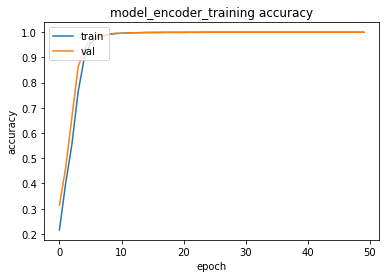

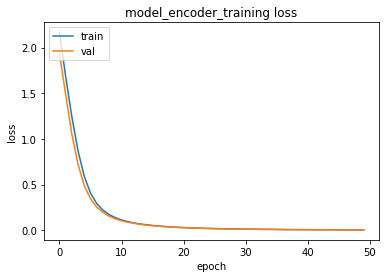

10 examples from test data...
Input          Expected       Predicted         T/F
[4, 5, 8, 6]   [6, 8, 5, 4]   [6, 8, 5, 4]   True
[3, 5, 2, 9]   [9, 2, 5, 3]   [9, 2, 5, 3]   True
[1, 9, 7, 7]   [7, 7, 9, 1]   [7, 7, 9, 1]   True
[7, 3, 6, 1]   [1, 6, 3, 7]   [1, 6, 3, 7]   True
[6, 7, 4, 7]   [7, 4, 7, 6]   [7, 4, 7, 6]   True
[4, 3, 5, 9]   [9, 5, 3, 4]   [9, 5, 3, 4]   True
[3, 9, 3, 3]   [3, 3, 9, 3]   [3, 3, 9, 3]   True
[1, 1, 1, 9]   [9, 1, 1, 1]   [9, 1, 1, 1]   True
[4, 5, 9, 6]   [6, 9, 5, 4]   [6, 9, 5, 4]   True
[4, 5, 5, 1]   [1, 5, 5, 4]   [1, 5, 5, 4]   True
Accuracy:  1.0


In [53]:
train_test(model_encoder_decoder_tf, [encoder_input_data, decoder_input_data], 
           decoder_predicted_data , [encoder_input_data, decoder_input_data], 
           decoder_predicted_data, epochs=50, batch_size=32, patience=5,verbose=2)

We observed that training is finalized almost 100% accuracy with validation training sets. 

It is notable that we execute validation and testing by just using the training data and Teacher Forcing in place.

Because:
* Teacher Forcing needs to know the correct output beforehand
* Teacher Forcing is a method for improving training process
* The model employing Teacher Forcing CAN NOT BE USED in inference/testing

Therefore,
* the model that we trained above CAN NOT BE DIRECTLY USED in inference/testing
* We will use some layers (with their weights) of the trained model to create a new model
* The new model will not use Teacher Learning
* Thus, the input to the new model will NOT BE [encoder_input_data, decoder_input_data] as the way we designed in model_encoder_training

Remember, 
* in Teacher Forcing, we set decoder_input_data such that it begins with a special symbol start and continues with the target sequence data except for the last time step.
* Now, during inference (testing), we do not know the correct (expected) target data beforehand!

We define the decoder_input_data as follows:
* it begins with a special symbol start
* it will continue with an input created by the decoder at the previous time step
* in other words, the decoder’s output at time step t will be used decoder’s input at time step t+1

We create a separate encoder model by using the trained layers in the above model. 

IMPORTANT: pay attention that in this model we use encoder_inputs, encoder_states for encoding which are parts of the encoder model, we trained above. That is, these layers come with its **trained weights** with Teacher Forcing


In [54]:
encoder_model = Model(encoder_inputs, encoder_states)

Then we create a separate decoder model by using the trained layers in the above model
* Design the decoder model by defining layers for:
* inputs
* decoding (LSTM)
* outputs

In [55]:
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

Even though we define the encoder and decoder models we still need to dynamically provide the decoder_input_data as follows:
* it begins with a special symbol start
* it will continue with an input created by the decoder at the previous time step
* in other words, the decoder’s output at time step t will be used decoder’s input at time step t+1

In [59]:
def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, n_features))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 0] = 1

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_seq = list()
    
    while not stop_condition:

        # in a loop
        # decode the input to a token/output prediction + required states for context vector
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # convert the token/output prediction to a token/output
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_digit = sampled_token_index
        
        # add the predicted token/output to output sequence
        decoded_seq.append(sampled_digit)
        

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_digit == '\n' or
           len(decoded_seq) == n_timesteps):
            stop_condition = True

        # Update the input target sequence (of length 1) 
        # with the predicted token/output 
        target_seq = np.zeros((1, 1, n_features))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update input states (context vector) 
        # with the ouputed states
        states_value = [h, c]

        # loop back.....
        
    # when loop exists return the output sequence
    return decoded_seq

We can now put the encoder model and decoder model together by using the function above for inference as below:

In [60]:
print('Input \t\t\t  Expected  \t   Predicted \t\tT/F')
correct = 0 
sampleNo = 10

for sample in range(0,sampleNo):
    predicted = decode_sequence(encoder_input_data[sample].reshape(1, n_timesteps, n_features))
    if (one_hot_decode(decoder_predicted_data[sample]) == predicted):
        correct += 1
    print( one_hot_decode(encoder_input_data[sample]), '\t\t', 
        one_hot_decode(decoder_predicted_data[sample]),'\t', predicted,
        '\t\t',one_hot_decode(decoder_predicted_data[sample]) == predicted)
    
print('Accuracy: ', correct/sampleNo)

Input 			  Expected  	   Predicted 		T/F
[4, 5, 8, 6] 		 [6, 8, 5, 4] 	 [6, 8, 5, 4] 		 True
[3, 5, 2, 9] 		 [9, 2, 5, 3] 	 [9, 2, 5, 3] 		 True
[1, 9, 7, 7] 		 [7, 7, 9, 1] 	 [7, 7, 9, 1] 		 True
[7, 3, 6, 1] 		 [1, 6, 3, 7] 	 [1, 6, 3, 7] 		 True
[6, 7, 4, 7] 		 [7, 4, 7, 6] 	 [7, 4, 7, 6] 		 True
[4, 3, 5, 9] 		 [9, 5, 3, 4] 	 [9, 5, 3, 4] 		 True
[3, 9, 3, 3] 		 [3, 3, 9, 3] 	 [3, 3, 9, 3] 		 True
[1, 1, 1, 9] 		 [9, 1, 1, 1] 	 [9, 1, 1, 1] 		 True
[4, 5, 9, 6] 		 [6, 9, 5, 4] 	 [6, 9, 5, 4] 		 True
[4, 5, 5, 1] 		 [1, 5, 5, 4] 	 [1, 5, 5, 4] 		 True
Accuracy:  1.0


* Teacher Forcing is a method to train encoder-decoder models in Seq2Seq model to accelerate training
* Teacher Forcing can ONLY be used at Training
* We need to handle how to use the model in inference
* Even though Teacher Forcing improves the training process by fast converging, in the inference the model can generate low accuracy even with the training data.
* Therefore, we need to use Teacher Forcing with caution

### How to handle variable input and output sequence size

Previously, we assumed that input and output sequence sizes of all samples are fixed and known in advance.
Now, we relax this requirement by assuming input & output sequence sizes may vary from sample to sample.

However, in Artificial Neural Network models (including encoder decoder models), the first and last layers have a fixed number of neurons and during training, we need to provide fixed-size samples in the input (X) and output (y) data sets.

Therefore, ANN models should be trained with samples structured in a fixed-size shape.However, since we have variable-size input/output samples, we need to convert them into a fixed-size shape.
The popular solution has two parts:
* During training: we will use padding and masking to make all sample sequence sizes equal.
* During inference: For variable output sequence size, we will modify the decoder such that it will work in a loop and stop generating output when a condition is met. This condition can be in satisfied in two ways:
    * If the decoder generated the maximum number of outputs defined by the user, or
    * If the decoder generated a special "STOP" symbol

#### How to use padding in variable-size input/output sequences?

* First, we will find out the maximum number of time steps in input/output data sets
* Then, we will append the necessary number of paddings to the end of each sequence such that their number of time steps will be equal to the maximum number of time steps in the data set.
* In the end, all the input/output sequences will have the same number of time steps

Here prepare a rather simple sequence learning problem.

Consider two parallel sequence datasets X and y as below:

X[0]=[3, 2, 9, 4]..................................y[0]=[4, 2]

X[1]=[7, 6, 5, 2, 5, 2].......................... y[1]=[2, 2, 6]

X[2]=[1, 7, 5, 1, 3]...............................y[2]=[]

NOTICE THAT input (X) and output (y) sequences have variable lengths

Actually, for this simple Seq2Seq Learning problem, I formulated the y sequence to be the even numbers of the given sequence (X) in reverse order.

We will assume that we do not know that relation: We only have 2 parallel datasets X and y

In this part, we will develop an encoder-decoder model for the above variable-size input and output sequences

In [11]:
## Functions to generate Seq2Seq Dataset, one hot encode / decode Input & Output Sequences

# generate a sequence of random integers
def generate_sequence(min_timesteps_in, max_timesteps_in, n_unique):
    return [randint(1, n_unique-1) for _ in 
            range(randint(min_timesteps_in, max_timesteps_in))]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)


# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]


# prepare data for the LSTM
def get_reversed_pairs(min_timesteps_in, max_timesteps_in,vocabulary_size,verbose= False):
    # generate random sequence
    sequence_in = generate_sequence(min_timesteps_in, max_timesteps_in, vocabulary_size)
    sequence_out = sequence_in[::-1]
    sequence_out =[i for i in sequence_out if i%2 ==0 and i != 0]
    
    # one hot encode
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)

    return X,y


def create_dataset(train_size, test_size, 
                   min_timesteps_in, max_timesteps_in, vocabulary_size, verbose= False):
    pairs = [get_reversed_pairs(min_timesteps_in, max_timesteps_in,vocabulary_size) for _ in range(train_size)]
    
    pairs=np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]
    pairs = [get_reversed_pairs(min_timesteps_in, max_timesteps_in,vocabulary_size) for _ in range(test_size)]
    pairs = np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]	

    if(verbose):
        print('\nSample X and y sequences (in Raw Format)')
        for i in range(5):
            print('X[',i,']=%s' % (one_hot_decode(X_train[i])), '........ y[',i,']=%s' % (one_hot_decode(y_train[i])))

        print('\nEach input and output sequences are converted one_hot_encoded format with input_dimension = ',
              vocabulary_size)
        print('X[0]=\n%s' % (X_train[0]))
        print('y[0]=\n%s' % (y_train[0]))
    
        print('\nGenerated sequence datasets as follows [sample_size,time_steps, input_dimension]')
        print('X_train.shape: ', X_train.shape,'y_train.shape: ', y_train.shape)
        print('X_test.shape: ', X_test.shape,'y_test.shape: ', y_test.shape)

    return X_train, y_train, X_test, y_test

In [12]:
# Configure parameters of the model and dataset

min_timesteps_in =   4
max_timesteps_in =   8

input_dimension = 10   

# generate datasets
train_size= 4000 
test_size = 200  

X_train, y_train , X_test, y_test=create_dataset(train_size, test_size, min_timesteps_in, max_timesteps_in, input_dimension, verbose=True)


Sample X and y sequences (in Raw Format)
X[ 0 ]=[6, 4, 9, 1] ........ y[ 0 ]=[4, 6]
X[ 1 ]=[8, 5, 2, 7, 9, 8] ........ y[ 1 ]=[8, 2, 8]
X[ 2 ]=[1, 8, 9, 8, 9, 8, 6, 8] ........ y[ 2 ]=[8, 6, 8, 8, 8]
X[ 3 ]=[9, 1, 8, 6, 6, 9, 9, 8] ........ y[ 3 ]=[8, 6, 6, 8]
X[ 4 ]=[1, 7, 2, 6, 5, 4] ........ y[ 4 ]=[4, 6, 2]

Each input and output sequences are converted one_hot_encoded format with input_dimension =  10
X[0]=
[[0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0]]
y[0]=
[[0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]

Generated sequence datasets as follows [sample_size,time_steps, input_dimension]
X_train.shape:  (4000,) y_train.shape:  (4000,)
X_test.shape:  (200,) y_test.shape:  (200,)


/tmp/ipykernel_123372/2107157399.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pairs=np.array(pairs).squeeze()
/tmp/ipykernel_123372/2107157399.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pairs = np.array(pairs).squeeze()


In [13]:
# First we will find out the **maximum** sequence size for input/output sequences 

max_input_sequence= max(len(seq) for seq in X_train)
max_output_sequence= max(len(seq) for seq in y_train)

print('max_input_sequence: ', max_input_sequence)
print('max_output_sequence: ', max_output_sequence)

max_input_sequence:  8
max_output_sequence:  8


In this example, max_input_sequence and max_ouput_sequence are equal but they could be different for different datasets. The point is we need to handle input and output sequences separately!

Then, we will append necessary number of paddings to the end of each input sequence such that their number of time steps will be equal to the maximum number of time steps in the data set.

We can use pad_sequences() function from Keras preprocessing library as below.

`pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.0)`

Note that:

If the maxlen argument is NOT provided, the function automatically sets maxlen to the maximum sequence size in the samples. However, for the sake of clarity, we will provide max_input_sequence and max_ouput_sequence to the pad_sequences() function.

We will provide the padding value as [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] which is the one-hot-encoded representation of 0 (zero) padding!

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(X_train, maxlen= max_input_sequence, 
                               padding='post', value=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
print("X_train shape: ", X_train.shape)
print("X_train_padded shape: ", X_train_padded.shape)

y_train_padded = pad_sequences(y_train, maxlen= max_output_sequence, 
                               padding='post', value=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
print("y_train shape: ", y_train.shape)
print("y_train_padded shape: ", y_train_padded.shape)

X_train shape:  (4000,)
X_train_padded shape:  (4000, 8, 10)
y_train shape:  (4000,)
y_train_padded shape:  (4000, 8, 10)


**Important:** After padding, each sequence in X_train_padded has the same shape: (4000, 8, 10): 8 time steps with a 10-dimension representation! That is, we have fixed-size input data set!

Let's see an example input before and after padding:

In [20]:
i = 0
print("____Sample Input (Raw Format)____")
print("Original:\n", one_hot_decode(X_train[i]))
print("Padded:\n",one_hot_decode(X_train_padded[i]))
print()
print("____Corresponding Output (Raw Format)____")
print("Original:\n", one_hot_decode(y_train[i]))
print("Padded:\n",one_hot_decode(y_train_padded[i]))

____Sample Input (Raw Format)____
Original:
 [6, 4, 9, 1]
Padded:
 [6, 4, 9, 1, 0, 0, 0, 0]

____Corresponding Output (Raw Format)____
Original:
 [4, 6]
Padded:
 [4, 6, 0, 0, 0, 0, 0, 0]


We will apply padding to the test data as well.

In [21]:
X_test_padded = pad_sequences(X_test, maxlen= max_input_sequence, padding='post', 
                              value=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
print("X_test shape: ",X_test.shape)
print("X_test_padded shape: ",X_test_padded.shape)

y_test_padded = pad_sequences(y_test, maxlen= max_output_sequence, padding='post', 
                              value=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
print("y_test shape: ",y_test.shape)
print("y_test_padded shape: ",y_test_padded.shape)

X_test shape:  (200,)
X_test_padded shape:  (200, 8, 10)
y_test shape:  (200,)
y_test_padded shape:  (200, 8, 10)


*Masking*

Masking is a way to tell sequence-processing layers that certain timesteps in an input are missing, and thus should be skipped when processing the data.

Above we applied padding and all samples have a uniform sequence length.

Now, we need to inform the model that some part of the data is actually padding and should be ignored during processing.

That mechanism is called "masking".

There are three ways to introduce input masks in Keras models:
* Add a keras.layers.Masking layer.
* Configure a keras.layers.Embedding layer with mask_zero=True.
* Pass a mask argument manually when calling layers that support this argument (e.g. RNN layers).
* In this tutorial, we will use Masking layer. It is worth remembering that we padded the sequences with 0 (zero) value. However, 0 value is converted one-hot encoding. Thus, the mask value is the one-hot-encoded representation of 0 (zero) which is [1 0 0 0 0 0 0 0 0 0]

Therefore, we will create a Masking layer as below:

`masking = tf.keras.layers.Masking(mask_value= [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])`

#### Encoder-Decoder model with teacher forcing on  variable input-output

We need to provide 2 input sequences to train an Encoder - Decoder model with teacher forcing such that

input to encoder: [4 7 2 0 0 0 0 0]

input to decoder: [0 2 4 0 0 0 0 0]

**Note that:**
* Expected output is [2 4 0 0 0 0 0 0] ----even numbers in reverse order of input to encoder
* 0 (zero) is selected as special symbol for 'start' and 'padding'
* input to decoder is created by shifting the expected output by one time steps and adding 'start' token as the first token: [2 4 0 0 0 0 0 0] ------> [0 2 4 0 0 0 0 0]
* At the first cycle, decoder will use encoder's state and its first input which is 0 ([1 0 0 0 0 0 0 0]) from [0 2 4 0 0 0 0 0] to generate the first expected output which is 2 from [2 4 0 0 0 0 0 0]

Assume that decoder predicts 5
* in generic Encoder-Decoder model decoder will use 5 to generate/predict next token
* in teacher forcing, we (the teacher!) provide the second input from [0 2 4 0 0 0 0 0] which is 2 to the decoder to generate/predict next token
* Thus, during training, teacher enforces the decoder to condition itself to generate/predict next token according to the given correct input!

We need 2 input sequences:
* Input for encoder: encoder_inputs
* Input for decoder: decoder_inputs

The encoder_inputs is given
* However, this time we do not have correct outputs
* Therefore, we will provide the predicted output as the input.
* The first input is 'start' and the other inputs will be the outputs from previous cycle

In [15]:
# Prepare Train data set
encoder_input_data = X_train_padded.copy()
decoder_target_data = y_train_padded.copy()
decoder_input_data = decoder_target_data.copy()
for i, samples in enumerate(decoder_target_data):
    seq = one_hot_decode(samples)
    shifted = shift(seq, 1, cval=0)
    decoder_input_data[i] = one_hot_encode(shifted,input_dimension)
    
print("Data for Train")
print('encoder_input_data (X): ', one_hot_decode(encoder_input_data[1]))
print('decoder_input_data (teacher forcing): ', one_hot_decode(decoder_input_data[1]))
print('decoder_target_data (y):', one_hot_decode(decoder_target_data[1]))
print(encoder_input_data.shape)

# Prepare Test data set
encoder_input_test = X_test_padded.copy()
decoder_target_test = y_test_padded.copy()
decoder_input_test= decoder_target_test.copy()
for i, samples in enumerate(decoder_target_test):
    seq = one_hot_decode(samples)
    shifted= shift(seq, 1, cval=0)
    decoder_input_test[i] = one_hot_encode(shifted, input_dimension)

NameError: name 'X_train_padded' is not defined

In [27]:
LSTMoutputDimension = 32

# Define an input sequence and process it.
encoder_inputs = Input(shape=(max_input_sequence, input_dimension), name='encoder_inputs')

masking = tf.keras.layers.Masking(mask_value= [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
encoder_inputs_masked = masking(encoder_inputs)


encoder_lstm = LSTM(LSTMoutputDimension, return_state=True, name='encoder_lstm')
LSTM_outputs, state_h, state_c = encoder_lstm(encoder_inputs_masked)


# We discard `LSTM_outputs` and only keep the other states.
encoder_states = [state_h, state_c]



decoder_inputs = Input(shape=(None, input_dimension), name='decoder_inputs')
decoder_lstm = LSTM(LSTMoutputDimension, return_sequences=True, return_state=True, name='decoder_lstm')

# Set up the decoder, using `context vector` as initial state.
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

# We complete the decoder model by adding a Dense layer with Softmax activation function 
# for prediction of the next output
# Dense layer will output one-hot encoded representation as we did for input
# Therefore, we will use input_dimension number of neurons
decoder_dense = Dense(input_dimension, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# put together
model_encoder_training = Model([encoder_inputs, decoder_inputs], 
                               decoder_outputs, name='model_encoder_training')

2021-10-20 20:42:10.712622: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-20 20:42:10.842673: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-20 20:42:11.874312: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-20 20:42:11.874435: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (HYDLPT1108): /proc/driver/nvidia/version does not exist
2021-10-20 20:42:11.876412: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-20 20:42:1

Model: "model_encoder_training"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 8, 10)]      0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 8, 10)        0           encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None, 10)]   0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 32), (None,  5504        masking[0][0]                    
_____________________________________________________________________________

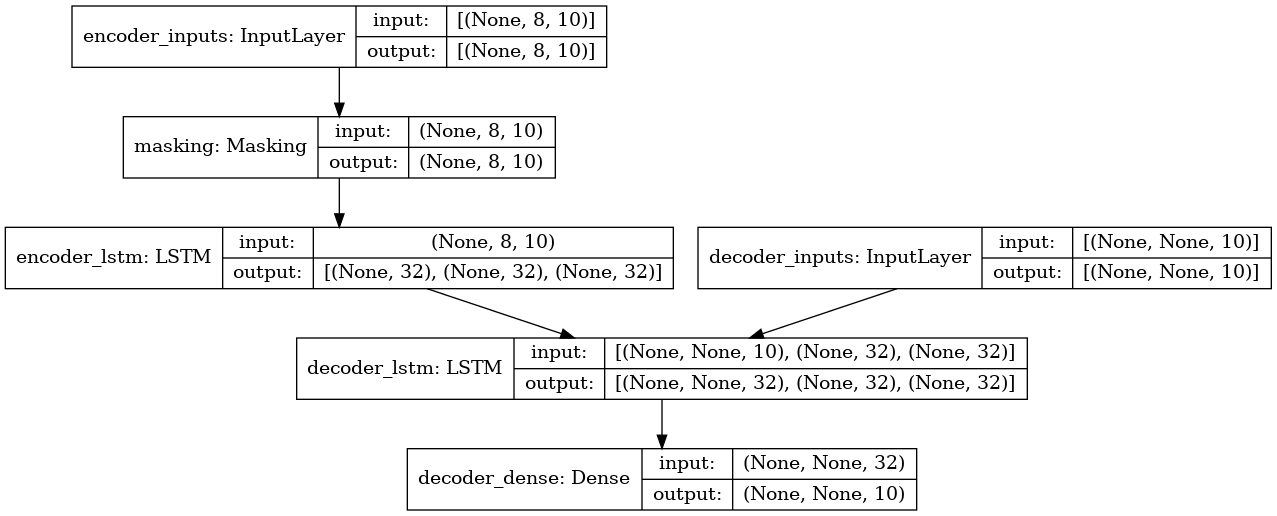

In [28]:
model_encoder_training.compile(optimizer='adam', loss='categorical_crossentropy', 
                               metrics=['accuracy'])

model_encoder_training.summary()
plot_model(model_encoder_training, show_shapes=True)

training for  50  training for  50  epochs begins with EarlyStopping while monitoring val_loss...


2021-10-20 20:43:59.386884: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-20 20:43:59.494489: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1999965000 Hz


Epoch 1/50
57/57 - 5s - loss: 1.7232 - accuracy: 0.5765 - val_loss: 1.0071 - val_accuracy: 0.6756
Epoch 2/50
57/57 - 0s - loss: 0.8188 - accuracy: 0.6959 - val_loss: 0.6579 - val_accuracy: 0.7316
Epoch 3/50
57/57 - 0s - loss: 0.5945 - accuracy: 0.7509 - val_loss: 0.5259 - val_accuracy: 0.7875
Epoch 4/50
57/57 - 0s - loss: 0.5102 - accuracy: 0.7984 - val_loss: 0.4721 - val_accuracy: 0.8213
Epoch 5/50
57/57 - 0s - loss: 0.4509 - accuracy: 0.8361 - val_loss: 0.4040 - val_accuracy: 0.8553
Epoch 6/50
57/57 - 0s - loss: 0.3864 - accuracy: 0.8552 - val_loss: 0.3570 - val_accuracy: 0.8675
Epoch 7/50
57/57 - 0s - loss: 0.3438 - accuracy: 0.8670 - val_loss: 0.3165 - val_accuracy: 0.8737
Epoch 8/50
57/57 - 0s - loss: 0.3046 - accuracy: 0.8773 - val_loss: 0.2786 - val_accuracy: 0.8881
Epoch 9/50
57/57 - 0s - loss: 0.2695 - accuracy: 0.8897 - val_loss: 0.2471 - val_accuracy: 0.9050
Epoch 10/50
57/57 - 0s - loss: 0.2379 - accuracy: 0.9081 - val_loss: 0.2165 - val_accuracy: 0.9241
Epoch 11/50
57/57 -

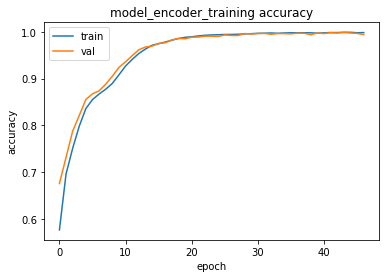

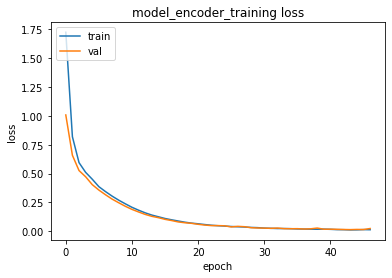

10 examples from test data...
Input                      Expected                   Predicted                     T/F
[4, 5, 8, 8, 5, 0, 0, 0]   [8, 8, 4, 0, 0, 0, 0, 0]   [8, 8, 4, 0, 0, 0, 0, 0]   True
[8, 3, 4, 8, 0, 0, 0, 0]   [8, 4, 8, 0, 0, 0, 0, 0]   [8, 4, 8, 0, 0, 0, 0, 0]   True
[7, 1, 7, 7, 3, 0, 0, 0]   [0, 0, 0, 0, 0, 0, 0, 0]   [0, 0, 0, 0, 0, 0, 0, 0]   True
[7, 5, 1, 9, 1, 7, 0, 0]   [0, 0, 0, 0, 0, 0, 0, 0]   [0, 0, 0, 0, 0, 0, 0, 0]   True
[5, 2, 3, 6, 0, 0, 0, 0]   [6, 2, 0, 0, 0, 0, 0, 0]   [6, 2, 0, 0, 0, 0, 0, 0]   True
[1, 6, 8, 4, 0, 0, 0, 0]   [4, 8, 6, 0, 0, 0, 0, 0]   [4, 8, 6, 0, 0, 0, 0, 0]   True
[3, 6, 1, 1, 4, 0, 0, 0]   [4, 6, 0, 0, 0, 0, 0, 0]   [4, 6, 0, 0, 0, 0, 0, 0]   True
[5, 2, 7, 2, 7, 0, 0, 0]   [2, 2, 0, 0, 0, 0, 0, 0]   [2, 2, 0, 0, 0, 0, 0, 0]   True
[1, 3, 3, 1, 6, 0, 0, 0]   [6, 0, 0, 0, 0, 0, 0, 0]   [6, 0, 0, 0, 0, 0, 0, 0]   True
[3, 6, 4, 6, 7, 6, 0, 0]   [6, 6, 4, 6, 0, 0, 0, 0]   [6, 6, 4, 6, 0, 0, 0, 0]   True
Accuracy:  1.0


In [29]:
train_test(model_encoder_training, [encoder_input_data, decoder_input_data], decoder_target_data ,
           [encoder_input_test, decoder_input_test], 
           decoder_target_test, epochs=50, batch_size=64, patience=3, verbose=2)

#### Inference Model:
We create a separate encoder model by using the trained layers in the above model. For example, in the following model, we will use encoder_inputs, encoder_states for encoding which are parts of the encoder model, we trained above. That is, these layers come with its trained weights with Teacher Forcing

In [30]:
encoder_model = Model(encoder_inputs, encoder_states)

Then we create a separate decoder model by using the trained layers in the above model. Then we design the decoder model by defining layers for:
* Inputs
* decoding (LSTM)
* outputs

**IMPORTANT:** We need to pay attention that in this model we use decoder_lstm for decoding which is a part of the decoder model we trained above i.e. this layer comes with its trained weights with Teacher Forcing

In [31]:
decoder_state_input_h = Input(shape=(LSTMoutputDimension,))
decoder_state_input_c = Input(shape=(LSTMoutputDimension,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

Even though we define the encoder and decoder models we still need to dynamically provide the decoder_input_data as follows:
* it begins with a special symbol start
* it will continue with an input created by the decoder at previous time step
* in other words, decoder's output at time step t will be used decoder's input at time step t+1

In [32]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, input_dimension))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 0] = 1 
    # START (0 zero) in one-hot-encoding --> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_seq = list()
    
    while not stop_condition:

        # in a loop
        # decode the input to a token/output prediction + required states for context vector
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # convert the token/output prediction to a token/output
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = sampled_token_index
        # add the predicted token/output to output sequence
        decoded_seq.append(sampled_char)
        

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == 0 or
           len(decoded_seq) == max_output_sequence):
            stop_condition = True

        # Update the input target sequence (of length 1) 
        # with the predicted token/output 
        target_seq = np.zeros((1, 1, input_dimension))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update input states (context vector) 
        # with the ouputed states
        states_value = [h, c]

        # loop back.....
        
    # when loop exists return the output sequence
    return decoded_seq

In [33]:
print('Input \t\t\t\t\t  Expected  \t\t\t   Predicted \t\tT/F')
correct =0 
sampleNo =  10
for sample in range(0,sampleNo):
    predicted= decode_sequence(encoder_input_data[sample].
                             reshape(1,max_input_sequence,input_dimension))
    if (one_hot_decode(decoder_target_data[sample])== predicted+ [0] * (max_output_sequence- len(predicted))):
        correct+=1
    print(one_hot_decode(encoder_input_data[sample]), '\t\t', 
          one_hot_decode(decoder_target_data[sample]),'\t', predicted,
          '\t\t',one_hot_decode(decoder_target_data[sample]) == predicted + [0] * (max_output_sequence- len(predicted)))
print('Accuracy: ', correct/sampleNo)

Input 					  Expected  			   Predicted 		T/F
[6, 4, 9, 1, 0, 0, 0, 0] 		 [4, 6, 0, 0, 0, 0, 0, 0] 	 [4, 6, 0] 		 True
[8, 5, 2, 7, 9, 8, 0, 0] 		 [8, 2, 8, 0, 0, 0, 0, 0] 	 [8, 2, 8, 0] 		 True
[1, 8, 9, 8, 9, 8, 6, 8] 		 [8, 6, 8, 8, 8, 0, 0, 0] 	 [8, 6, 8, 8, 8, 0] 		 True
[9, 1, 8, 6, 6, 9, 9, 8] 		 [8, 6, 6, 8, 0, 0, 0, 0] 	 [8, 6, 6, 8, 0] 		 True
[1, 7, 2, 6, 5, 4, 0, 0] 		 [4, 6, 2, 0, 0, 0, 0, 0] 	 [4, 6, 2, 0] 		 True
[5, 6, 4, 4, 1, 4, 0, 0] 		 [4, 4, 4, 6, 0, 0, 0, 0] 	 [4, 4, 4, 6, 0] 		 True
[1, 7, 3, 2, 1, 0, 0, 0] 		 [2, 0, 0, 0, 0, 0, 0, 0] 	 [2, 0] 		 True
[1, 8, 6, 2, 6, 0, 0, 0] 		 [6, 2, 6, 8, 0, 0, 0, 0] 	 [6, 2, 6, 8, 0] 		 True
[5, 1, 4, 1, 7, 7, 0, 0] 		 [4, 0, 0, 0, 0, 0, 0, 0] 	 [4, 0] 		 True
[3, 1, 7, 5, 5, 4, 9, 0] 		 [4, 0, 0, 0, 0, 0, 0, 0] 	 [4, 0] 		 True
Accuracy:  1.0


**Notice that:** Decoder stops whenever it generates 0 (zero)

Observations:
* Data set (X or y) can have samples whose lengths (time steps) can be different (variable)
* We use padding for appending a special symbol to sequences.
* We can pad as many as needed for a sequence to make its length equal to the maximum length in the data set.
* We use masking to tell the layer to skip these time steps since they hold padding values.
* Teacher Forcing is a method to train encoder-decoder models in Seq2Seq model to accelerate training
* Teacher Forcing can ONLY be used at Training
* We need to handle how to use the model in inference

## Attention Mechanism

According to the inventors of Bahdanau Attention:

"One of the motivations behind the proposed approach (attention mechanism) was the use of a fixed-length context vector in the basic encoder–decoder approach. We conjectured that this limitation may make the basic encoder–decoder approach to underperform with long sentences. "

We can check the validity of these arguments by increasing the sequence size (n_timesteps_in) to 16.

Remember that when the sequence size (n_timesteps_in) is 4 (Encoder-Decoder model terminates at Epoch 31 with 99% accuracy.
However, when the sequence size (n_timesteps_in) is 16 Encoder-Decoder model runs all the 40 epochs and finishes with only 36% accuracy! i.e. as argued, Encoder Decoder model underperforms with long sequences.

### How it works?

According to the inventors:

"The proposed approach provides an intuitive way to inspect the (soft-) alignment between the words in a generated translation and those in a source sentence".

To understand how the attention mechanism works, we first compare the Encoder-Decoder Model we coded above with an Encoder-Decoder model including the attention mechanism in figures

![title](assets/AE_eg.png)

Note that:

In the above figure, in the Encoder-Decoder Model we have coded, 
* we use only the decoder's last hidden and cell states
* the decoder's states as an initial context vector only once

In the below figure, the Encoder-Decoder model with the attention mechanism:
* We use not only the last hidden and cell states but also the decoder's hidden states generated at all the time steps
* We use all the decoder's hidden states at all consecutive time steps

Basically:
* First, we initialize the Decoder states by using the last states of the Encoder as usual
* Then at each decoding time step:
    * We use Encoder's all hidden states and the previous Decoder's output to calculate a Context Vector by applying an Attention Mechanism
    * Lastly, we concatenate the Context Vector with the previous Decoder's output to create the input to the decoder.

We will see a more detailed explanation about the model after discussing and implementing Bahdanau attention.

![title](assets/AE_att_eg.png)

### Attention: How to calculate Context Vector

According to "Effective Approaches to Attention-based Neural Machine Translation" by Minh-Thang Luong, Hieu Pham, Christopher D. Manning, the attention mechanism above is called "Global Attention":

"The idea of a global attentional model is to consider all the hidden states of the encoder  h<sub>s</sub>  when deriving the context vector  c<sub>t</sub> "

That is, we attend to all the decoder outputs for generating each decoder's output as follows:

Notation

h<sub>s</sub> : all the hidden states of the encoder

h<sub>t</sub> : previous hidden states of the decoder (previous time step output)

c<sub>t</sub> : context vector

W : Weight matrix for parametrizing the calculations

#### Calculate a score to relate the Encoder's all hidden states and the previous Decoder's output

There are many different scores proposed by researchers. The most important ones are:

![att_formula](assets/att_formula.jpeg)

We can think of these scores as the level of relationship between the Encoder's all hidden states and the previous Decoder's output.

We use  W  matrices to parametrize the calculations. That is, we will learn the weight values during training via backprop. The model will learn how to calculate better scores.

**tanh** is a single hidden layer network model here.

**v** is another single hidden layer network model here.

As a result of above model, we expect that these layers ( **W,tanh,v** ) will learn how to calculate a suitable score during training.

#### Calculate the **Attention Weights** by normalizing the scores.

These are the weights for each decoder hidden state  hs .

Simply, we can use softmax() to calculate the probability distribution.

![formula](assets/att_normalize.png)

We calculate the Context Vector by applying the Attention Weights onto decoder hidden states h<sub>s</sub>.
Thus, we will have weighted decoder hidden states h<sub>s</sub> at the end

![formula](assets/context.png)

After calculating the context vector, we can concatenate it with the previous decoder hidden state (output) to generate the input for the next decoder output.

### Let's code Bahdanau Attention Layer

First, We would like to look at the core code snippet:

![formula](assets/encoder_attention_code.png)

* This has been borrowed from the Tensorflow official web site.
* Necessary comments to relate the formula above with the code below has been added.
* Please pay attention to each tensor dimensions. That is really important for understanding how it all works together!

In [3]:
class BahdanauAttention(tf.keras.layers.Layer):
    
    def __init__(self, units, verbose=0):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.verbose= verbose

    def call(self, query, values):
        if self.verbose:
            print('\n******* Bahdanau Attention STARTS******')
            print('query (decoder hidden state): (batch_size, hidden size) ', query.shape)
            print('values (encoder all hidden state): (batch_size, max_len, hidden size) ', values.shape)

        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        if self.verbose:
            print('query_with_time_axis:(batch_size, 1, hidden size) ', query_with_time_axis.shape)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))
        if self.verbose:
            print('score: (batch_size, max_length, 1) ',score.shape)
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        if self.verbose:
            print('attention_weights: (batch_size, max_length, 1) ',attention_weights.shape)
    
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        if self.verbose:
            print('context_vector before reduce_sum: (batch_size, max_length, hidden_size) ',context_vector.shape)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        if self.verbose:
            print('context_vector after reduce_sum: (batch_size, hidden_size) ',context_vector.shape)
        print('\n******* Bahdanau Attention ENDS******')
        return context_vector, attention_weights

#### Integrating the attention layer into the Encoder Decoder model

In an Encoder Decoder with Attention Layer set-up,

Encoder provides:
* the initial states by sending its last hidden state + last cell state
* the context vector by sending its all hidden states

Decoder:
* needs 2 inputs to generate / predict an output:
    * an input tensor
    * a state tensor
* initializes its state by consuming the initial states
* uses decoder's last hidden state as the initial input
* calculates attention vector using initial input + encoder's all hidden states
* applies the attention to encoder's all hidden states finds the context vector
* concatenate context vector + START to generate the decoder input
* then runs in a loop:
    * consume the input and states
    * outputs its last hidden state, last hidden state (yes again!), last cell state,
    * use last hidden state + last cell state as the next state
    * use last hidden state as the next initial input
    * calculates attention vector using initial input + encoder's all hidden states
    * applies the attention to encoder's all hidden states finds the context vector
    * concatenate context vector+ initial input to generate the decoder input

In [29]:
def train_test(model, X_train, y_train , X_test, 	y_test, epochs=500, batch_size=32, patience=5,verbose=0):
    # patient early stopping
    es = EarlyStopping(monitor='val_accuracy', mode='max',  verbose=1, patience=patience)
    
    # train model
    print('training for ',epochs,' epochs begins with EarlyStopping(monitor= val_accuracy, patience=',patience,')....')
    history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,batch_size=batch_size, verbose=verbose, callbacks=[es])
    print(epochs,' epoch training finished...')

    # report training
    # evaluate model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
    _, test_acc = model.evaluate(X_test, 	y_test, batch_size=batch_size, verbose=0)
    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model.name+' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model.name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()




  
    # spot check some examples
    space = 3*len(one_hot_decode(y_test[0]))
    print('10 examples from test data...')
    print('Input',' '*(space-4) ,'Expected',' '*(space-7) ,
          'Predicted',' '*(space-5) ,'T/F')
    correct =0 
    sampleNo =  10

    predicted= model.predict(X_test[:sampleNo], batch_size=batch_size)
    for sample in range(0,sampleNo):
        if (one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample])):
            correct+=1
        print( one_hot_decode(X_test[sample]), ' ', 
                    one_hot_decode(y_test[sample]),' ', one_hot_decode(predicted[sample]),
                    ' ',one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample]))
    print('Accuracy: ', correct/sampleNo)

In [30]:
# generate a sequence of random integers
def generate_sequence(length, n_unique):
    return [randint(1, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_reversed_pairs(time_steps,vocabulary_size,verbose= False):
    # generate random sequence
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]
    
    # one hot encode
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)
    # reshape as 3D
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))

    if(verbose):
        print('\nFor each input sequence (X), selecting ',time_steps,' random numbers beteen 1 and ',
              vocabulary_size, ' (0 is reserved )')
         
        print('\nA sample X ')
        print('X=%s' % (one_hot_decode(X[0])))
        print('\nreversed input sequence (X) is the output sequence (y) ')
        print('y=%s' % (one_hot_decode(y[0])))
    
        print('\nEach input and output sequences are converted one_hot_encoded format in ',
              vocabulary_size,' dimensions')
        print('X=%s' % (X[0]))
        print('y=%s' % (y[0]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size, verbose= False):
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs = np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs = np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]	

    if(verbose):
        print('\nGenerated sequence datasets as follows (batch_size,time_steps, features)')
        print('X_train.shape: ', X_train.shape,'y_train.shape: ', y_train.shape)
        print('X_test.shape: ', X_test.shape,'y_test.shape: ', y_test.shape)

    return X_train, y_train, X_test, 	y_test

In [31]:
n_timesteps =  4
#each input sample has 4 values

n_features = 10  
#each value is one_hot_encoded with 10 0/1


# generate random sequence
X, y = get_reversed_pairs(n_timesteps,  n_features, verbose=True)

# generate datasets
train_size= 2000 
test_size = 200  

X_train, y_train , X_test, y_test=create_dataset(train_size, test_size, n_timesteps, n_features, verbose=True)


For each input sequence (X), selecting  4  random numbers beteen 1 and  10  (0 is reserved )

A sample X 
X=[6, 9, 5, 3]

reversed input sequence (X) is the output sequence (y) 
y=[3, 5, 9, 6]

Each input and output sequences are converted one_hot_encoded format in  10  dimensions
X=[[0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]]
y=[[0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0]]

Generated sequence datasets as follows (batch_size,time_steps, features)
X_train.shape:  (2000, 4, 10) y_train.shape:  (2000, 4, 10)
X_test.shape:  (200, 4, 10) y_test.shape:  (200, 4, 10)


In [32]:
latentSpaceDimension = 16 # length of each state vector

In [33]:
verbose = 0 
#See all debug messages

batch_size = 1

if verbose:
    print('***** Model Hyper Parameters *******')
    print('latentSpaceDimension: ', latentSpaceDimension)
    print('batch_size: ', batch_size)
    print('sequence length: ', n_timesteps)
    print('n_features: ', n_features)

    print('\n***** TENSOR DIMENSIONS *******')

# The first part is encoder
encoder_inputs = Input(shape=(n_timesteps, n_features), name='encoder_inputs')
encoder_lstm = LSTM(latentSpaceDimension,return_sequences=True, return_state=True,  name='encoder_lstm')
encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

if verbose:
    print ('Encoder output shape: (batch size, sequence length, latentSpaceDimension) {}'.format(encoder_outputs.shape))
    print ('Encoder Hidden state shape: (batch size, latentSpaceDimension) {}'.format(encoder_state_h.shape))
    print ('Encoder Cell state shape: (batch size, latentSpaceDimension) {}'.format(encoder_state_c.shape))
    
# initial context vector is the states of the encoder
encoder_states = [encoder_state_h, encoder_state_c]
if verbose:
    print(encoder_states)
    
# Set up the attention layer
attention= BahdanauAttention(latentSpaceDimension, verbose=verbose)


# Set up the decoder layers
decoder_inputs = Input(shape=(1, (n_features+latentSpaceDimension)),name='decoder_inputs')
decoder_lstm = LSTM(latentSpaceDimension,  return_state=True, name='decoder_lstm')
decoder_dense = Dense(n_features, activation='softmax',  name='decoder_dense')

all_outputs = []

# 1 initial decoder's input data
# Prepare initial decoder input data that just contains the start character 
# Note that we made it a constant one-hot-encoded in the model
# that is, [1 0 0 0 0 0 0 0 0 0] is the first input for each loop
# one-hot encoded zero(0) is the start symbol
inputs = np.zeros((batch_size, 1, n_features)).astype(np.float32)
inputs[:, 0, 0] = 1 


# 2 initial decoder's state
# encoder's last hidden state + last cell state
decoder_outputs = encoder_state_h
states = encoder_states
if verbose:
    print('initial decoder inputs: ', inputs.shape)

# decoder will only process one time step at a time.
for _ in range(n_timesteps):

    # 3 pay attention
    # create the context vector by applying attention to 
    # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
    context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)
    if verbose:
        print("Attention context_vector: (batch size, units) {}".format(context_vector.shape))
        print("Attention weights : (batch_size, sequence_length, 1) {}".format(attention_weights.shape))
        print('decoder_outputs: (batch_size,  latentSpaceDimension) ', decoder_outputs.shape )

    context_vector = tf.expand_dims(context_vector, 1)
    if verbose:
        print('Reshaped context_vector: ', context_vector.shape )

    # 4. concatenate the input + context vectore to find the next decoder's input
    inputs = tf.concat([context_vector, inputs], axis=-1)
    
    if verbose:
        print('After concat inputs: (batch_size, 1, n_features + hidden_size): ',inputs.shape )

    # 5. passing the concatenated vector to the LSTM
    # Run the decoder on one timestep with attended input and previous states
    decoder_outputs, state_h, state_c = decoder_lstm(inputs,
                                            initial_state=states)
    #decoder_outputs = tf.reshape(decoder_outputs, (-1, decoder_outputs.shape[2]))
  
    outputs = decoder_dense(decoder_outputs)
    # 6. Use the last hidden state for prediction the output
    # save the current prediction
    # we will concatenate all predictions later
    outputs = tf.expand_dims(outputs, 1)
    all_outputs.append(outputs)
    # 7. Reinject the output (prediction) as inputs for the next loop iteration
    # as well as update the states
    inputs = outputs
    states = [state_h, state_c]


# 8. After running Decoder for max time steps
# we had created a predition list for the output sequence
# convert the list to output array by Concatenating all predictions 
# such as [batch_size, timesteps, features]
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

# 9. Define and compile model 
model_encoder_decoder_Bahdanau_Attention = Model(encoder_inputs, 
                                                 decoder_outputs, name='model_encoder_decoder')
model_encoder_decoder_Bahdanau_Attention.compile(optimizer='rmsprop', 
                                                 loss='categorical_crossentropy', metrics=['accuracy'])


******* Bahdanau Attention ENDS******

******* Bahdanau Attention ENDS******

******* Bahdanau Attention ENDS******

******* Bahdanau Attention ENDS******


training for  40  epochs begins with EarlyStopping(monitor= val_accuracy, patience= 3 )....


2021-10-25 01:00:36.698761: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-25 01:00:36.822710: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1999965000 Hz


Epoch 1/40

******* Bahdanau Attention ENDS******

******* Bahdanau Attention ENDS******

******* Bahdanau Attention ENDS******

******* Bahdanau Attention ENDS******

******* Bahdanau Attention ENDS******

******* Bahdanau Attention ENDS******

******* Bahdanau Attention ENDS******

******* Bahdanau Attention ENDS******
1787/1800 [============================>.] - ETA: 0s - loss: 2.0065 - accuracy: 0.2622
******* Bahdanau Attention ENDS******

******* Bahdanau Attention ENDS******

******* Bahdanau Attention ENDS******

******* Bahdanau Attention ENDS******
1800/1800 [==============================] - 12s 4ms/step - loss: 2.0047 - accuracy: 0.2627 - val_loss: 1.4631 - val_accuracy: 0.4250
Epoch 2/40
1800/1800 [==============================] - 5s 3ms/step - loss: 1.4043 - accuracy: 0.4220 - val_loss: 1.1991 - val_accuracy: 0.4888
Epoch 3/40
1800/1800 [==============================] - 6s 3ms/step - loss: 1.0795 - accuracy: 0.5658 - val_loss: 0.3603 - val_accuracy: 0.9525
Epoch 4/40
18

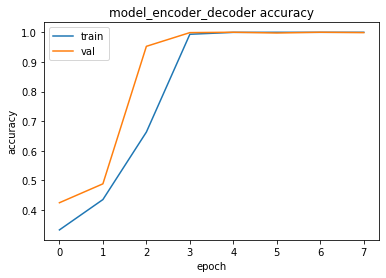

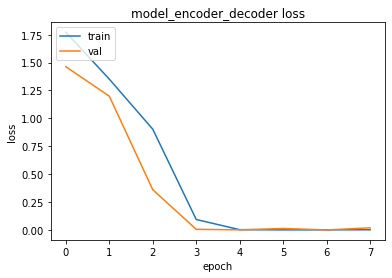

10 examples from test data...
Input          Expected       Predicted         T/F

******* Bahdanau Attention ENDS******

******* Bahdanau Attention ENDS******

******* Bahdanau Attention ENDS******

******* Bahdanau Attention ENDS******
[3, 2, 7, 4]   [4, 7, 2, 3]   [4, 7, 2, 3]   True
[8, 6, 4, 6]   [6, 4, 6, 8]   [6, 4, 6, 8]   True
[4, 4, 4, 8]   [8, 4, 4, 4]   [8, 4, 4, 4]   True
[5, 4, 6, 3]   [3, 6, 4, 5]   [3, 6, 4, 5]   True
[7, 9, 7, 9]   [9, 7, 9, 7]   [9, 7, 9, 7]   True
[7, 8, 2, 9]   [9, 2, 8, 7]   [9, 2, 8, 7]   True
[4, 5, 4, 7]   [7, 4, 5, 4]   [7, 4, 5, 4]   True
[1, 5, 7, 5]   [5, 7, 5, 1]   [5, 7, 5, 1]   True
[7, 7, 8, 4]   [4, 8, 7, 7]   [4, 8, 7, 7]   True
[2, 6, 7, 3]   [3, 7, 6, 2]   [3, 7, 6, 2]   True
Accuracy:  1.0


In [34]:
train_test(model_encoder_decoder_Bahdanau_Attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=40, patience=3, verbose=1)

#### Things to Observe:

When the sequence size (n_timesteps_in) is 4
* Encoder-Decoder model terminates at Epoch 31 with 99% accuracy.
* Encoder-Decoder model with Attention terminates at Epoch 9 with 100%

However, when the sequence size (n_timesteps_in) is 16
* Encoder-Decoder model runs all the 40 epochs and finishes with only 36% accuracy!.
* Encoder-Decoder model with Attention terminates at Epoch 16 with 99%

We can conclude that the Encoder-Decoder model with Attention is much more scalable in terms of sequence length.

In [36]:
# Predicting with trained model

pred=model_encoder_decoder_Bahdanau_Attention.predict(X_test[0].reshape(1,n_timesteps,n_features), batch_size=1)
print('input', one_hot_decode(X_test[0]))
print('expected', one_hot_decode(y_test[0]))
print('predicted', one_hot_decode(pred[0]))

input [3, 2, 7, 4]
expected [4, 7, 2, 3]
predicted [4, 7, 2, 3]


### Depicting the Attention

* For a sample input, we will record the attention values for each time step
* Then, we will use the color codes to depict the relation between inputs and outputs
* The lighter colors indicate higher values (attention)
* That is, the model pays more attention to some inputs when creating each output (prediction)
* The model learns where to look for to create the output!

In [45]:
def evaluate(seq_in):
    attention_plot = np.zeros((n_timesteps, n_timesteps))
    print ('attention_plot shape: (n_timesteps, n_timesteps) {}'.format(attention_plot.shape))


    #sequence = [7, 9, 8, 5]
    sequence = one_hot_encode(seq_in,n_features)
    encoder_inputs=np.array(sequence).reshape(1,n_timesteps,n_features)

    encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float32)
    print ('Encoder input shape: (batch size, sequence length, n_features) {}'.format(encoder_inputs.shape))


    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

    print ('Encoder output shape: (batch size, sequence length, latentSpaceDimension) {}'.format(encoder_outputs.shape))
    print ('Encoder Hidden state shape: (batch size, latentSpaceDimension) {}'.format(state_h.shape))
    print ('Encoder Cell state shape: (batch size, latentSpaceDimension) {}'.format(state_c.shape))
    # initial context vector is the states of the encoder
    states = [state_h, state_c]

    # Set up the attention layer
    #attention= BahdanauAttention(latentSpaceDimension)


    # Set up the decoder layers
    #decoder_inputs = Input(shape=(1, (n_features+latentSpaceDimension)))
    #decoder_lstm = LSTM(latentSpaceDimension,  return_state=True, name='decoder_lstm')
    #decoder_dense = Dense(n_features, activation='softmax',  name='decoder_dense')

    all_outputs = []

    #INIT DECODER
    # Prepare decoder input data that just contains the start character 0
    # Note that we made it a constant one-hot-encoded in the model
    # that is, [1 0 0 0 0 0 0 0 0 0] is the first input for each loop
    decoder_input_data = np.zeros((1, 1, n_features))
    decoder_input_data[:, 0, 0] = 1 
    # that is, [1 0 0 0 0 0 0 0 0 0] is the first input for each loop
    inputs = decoder_input_data
    #initial hiiden state
    decoder_outputs = state_h

    print('initial decoder inputs: ', inputs.shape)

    # decoder will only process one timestep at a time.
    for t in range(n_timesteps):

        # pay attention
        context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)



        print("Attention context_vector: (batch size, units) {}".format(context_vector.shape))
        print("Attention weights : (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()


        decoder_outputs=tf.expand_dims(decoder_outputs, 1)
        print('decoder_outputs: (batch_size, 1, latentSpaceDimension) ', decoder_outputs.shape )

        context_vector = tf.expand_dims(context_vector, 1)
        print('Reshaped context_vector: ', context_vector.shape )
        inputs = tf.concat([context_vector, inputs], axis=-1)
        #inputs = tf.concat([context_vector, inputs], axis=-1)
        print('After concat inputs: (batch_size, 1, n_features + hidden_size): ',inputs.shape )

        # passing the concatenated vector to the LSTM
        # Run the decoder on one timestep
        decoder_outputs, state_h, state_c = decoder_lstm(inputs,
                                              initial_state=states)
        #decoder_outputs = tf.reshape(decoder_outputs, (-1, decoder_outputs.shape[2]))

        outputs = decoder_dense(decoder_outputs)
        # Store the current prediction (we will concatenate all predictions later)
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        # Reinject the outputs as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]



    # Concatenate all predictions such as [batch_size, timesteps, features]
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    seq_out=one_hot_decode(decoder_outputs[0])

    return seq_in, seq_out, attention_plot

In [46]:
# function for plotting the attention weights
def plot_attention(attention, sequence, predicted_sequence):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [47]:
def translate(seq_in):
    seq_in, seq_out, attention_plot = evaluate(seq_in)

    print('Input: %s' % (seq_in))
    print('Predicted translation: {}'.format(seq_out))

    attention_plot = attention_plot[:len(seq_out), :len(seq_in)]
    plot_attention(attention_plot, seq_in, seq_out)

attention_plot shape: (n_timesteps, n_timesteps) (4, 4)
Encoder input shape: (batch size, sequence length, n_features) (1, 4, 10)
Encoder output shape: (batch size, sequence length, latentSpaceDimension) (1, 4, 16)
Encoder Hidden state shape: (batch size, latentSpaceDimension) (1, 16)
Encoder Cell state shape: (batch size, latentSpaceDimension) (1, 16)
initial decoder inputs:  (1, 1, 10)

******* Bahdanau Attention ENDS******
Attention context_vector: (batch size, units) (1, 16)
Attention weights : (batch_size, sequence_length, 1) (1, 4, 1)
decoder_outputs: (batch_size, 1, latentSpaceDimension)  (1, 1, 16)
Reshaped context_vector:  (1, 1, 16)
After concat inputs: (batch_size, 1, n_features + hidden_size):  (1, 1, 26)

******* Bahdanau Attention ENDS******
Attention context_vector: (batch size, units) (1, 16)
Attention weights : (batch_size, sequence_length, 1) (1, 4, 1)
decoder_outputs: (batch_size, 1, latentSpaceDimension)  (1, 1, 16)
Reshaped context_vector:  (1, 1, 16)
After concat 

/tmp/ipykernel_4811/3699032426.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_4811/3699032426.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)


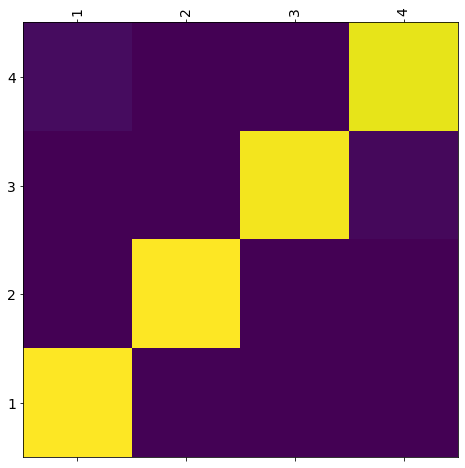

In [50]:
translate([1, 2, 3 ,4])

#### LuongAttention Layer

As we discussed, the only difference between Bahdanau and Luong Attention is the calculation of the score.

Here we use dot product for finding score as suggested by Luong et.al.

#LUONG Dot-product

``score = tf.transpose(tf.matmul(query_with_time_axis, values_transposed) , perm=[0, 2, 1])``

In [51]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        print('\n******* Luong Attention  STARTS******')
        print('query (decoder hidden state): (batch_size, hidden size) ', query.shape)
        print('values (encoder all hidden state): (batch_size, max_len, hidden size) ', values.shape)

        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        print('query_with_time_axis:(batch_size, 1, hidden size) ', query_with_time_axis.shape)


        values_transposed = tf.transpose(values, perm=[0, 2, 1])
        print('values_transposed:(batch_size, hidden size, max_len) ', values_transposed.shape)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        #BAHDANAU ADDITIVE:
        #score = self.V(tf.nn.tanh(
        #    self.W1(query_with_time_axis) + self.W2(values)))

        #LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, values_transposed) , perm=[0, 2, 1])

        print('score: (batch_size, max_length, 1) ',score.shape)
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        print('attention_weights: (batch_size, max_length, 1) ',attention_weights.shape)
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        print('context_vector before reduce_sum: (batch_size, max_length, hidden_size) ',context_vector.shape)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        print('context_vector after reduce_sum: (batch_size, hidden_size) ',context_vector.shape)


        print('\n******* Luong Attention ENDS******')
        return context_vector, attention_weights


Final Thoughts:
* We have discussed Encoder Decoder Model and observed that when the input sequence gets longer Encoder Decoder model can not relate the output to the input successfully
* We have seen that we can relate each output with each input by using an attention mechanism.
* In the experiments, the positive effect of attention mechanism on performance is clear.
* We implemented Bahdanau style (Additive) attention which is a global attention mechanism.
* Another global attention mechanism is Luong Attention (Multiplicative) in which only the calculation of the score values differs.
* As only dot product is used in Luong Attention (Multiplicative), it would be more efficient in terms of score calculations
* We can summarize the methods to find score values as below:

![scores](assets/scores.png)